<a href="https://colab.research.google.com/github/jianning1/Capstone-Project/blob/master/UPDATED_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Python Libaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import string
import spacy 
import os
import sys
import numpy as np

nlp = spacy.load('en', disable=['ner', 'parser'])
import nltk
from nltk.stem.snowball import SnowballStemmer
from scipy import stats

from time import time
from collections import defaultdict
import gc
import io
import random

from __future__ import print_function, division
from builtins import range
import os
import sys
import numpy as np
import operator

import nltk
nltk.download('all')
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize


import keras
from keras.models import Model, Sequential
from keras.layers import *
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalAveragePooling1D, Dropout, Conv1D, GRU, Layer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
from sklearn.metrics import roc_auc_score
import keras.backend as K
from keras.layers import CuDNNLSTM as LSTM
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras import metrics
from tensorflow.python.keras.metrics import Metric
from tensorflow.keras.utils import plot_model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.utils import shuffle, class_weight
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score, roc_auc_score, f1_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
# install tensorflow 2.0
!pip uninstall tensorflow
!pip install tensorflow-gpu==2.1.0

Uninstalling tensorflow-2.2.0rc3:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0rc3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0rc3
     |████████████████████████████████| 421.8MB 36kB/s 
     |████████████████████████████████| 3.9MB 50.5MB/s 
     |████████████████████████████████| 450kB 60.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=7fc3a2345cd7db1a6c100d015a8bf34c0e09c1eaf797f62f6bbc003b5764c6ad
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but 

In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [3]:
# check the availability of GPU
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [4]:
# Mount Google Drive (to save the downloaded files)
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### GloVe Pretrained Word Embedding loading

In [5]:
# Load GloVe Embeddings
print('Loading GloVe Embeddings.')

glove_embeddings = {}
f = open('/gdrive/My Drive/glove.42B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()

print('Found %s word vectors.' % len(glove_embeddings))


Loading GloVe Embeddings.
Found 1917495 word vectors.


# Import cleaned data

In [0]:
data = pd.read_csv('/gdrive/My Drive/cleaned_data.csv')

In [7]:
data.head(5)

Unnamed: 0  ...                                              texts
0           0  ...  yield cd fall late week new york    yield cert...
1           1  ...  morning brief   white house seek limit child i...
2           2  ...  banking bill negotiator set compromise    plan...
3           3  ...  manager journal   sniff drug abuser quick fix ...
4           4  ...  currency trading   dollar remain tight range a...

[5 rows x 6 columns]

# Text Classification

In [0]:
data = data[['texts','relevance']]

## Oversampling
Oversampling the minority by looking for the synonyms of each word in minor class

In [0]:
# use WordNet to find synonyms of each word and oversample the minor class
from nltk.corpus import wordnet 

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

In [0]:
# minor class data set
df = data[data['relevance']==1]

In [0]:
# function to oversample data
def oversample(wordlist): 
  new_words = wordlist
  for i in range(len(wordlist)):
    for random_word in wordlist[wordlist.index[i]]:
      try:
        synonyms = get_synonyms(random_word)  # find synonyms list of each word
        synonym = random.choice(list(synonyms))  # random select one sysnonym to replace the original word
        new_words[new_words.index[i]] = [synonym if word == random_word else word for word in new_words[new_words.index[i]]]
      except:
        pass
    s = ' '.join(new_words[new_words.index[i]]) # join the list of synonyms to a new sentence
    new_words[new_words.index[i]] = s
  augmented_sentences = pd.DataFrame(columns=['texts','relevance'])
  augmented_sentences['texts'] = new_words
  augmented_sentences['relevance']  = df['relevance']
  return augmented_sentences

In [0]:
# oversample the minor class data twice
sentence = df['texts']
word_list = sentence.str.split()
data_cleaned = data[['texts','relevance']]

random.seed(45)
data_cleaned = data_cleaned.append(oversample(word_list))

random.seed(98)
data_cleaned = data_cleaned.append(oversample(word_list))

In [13]:
dist = data_cleaned.groupby('relevance').count()
dist

texts
relevance       
0           6571
1           4260

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


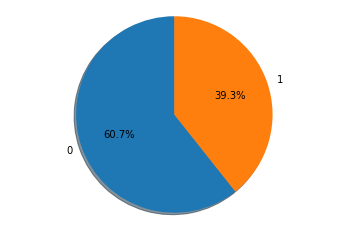

In [14]:

# pie chart of distribution of news relevance
fig1, ax1 = plt.subplots()
sizes = dist.values
label = dist.index.tolist()

ax1.pie(sizes, labels=label, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')    
plt.show()

In [0]:
# to ramdom shuffle data
data_cleaned = shuffle(data_cleaned)

In [0]:
# reset data index
data_cleaned = data_cleaned.reset_index()

In [17]:
data_cleaned.head(5)

index                                              texts  relevance
0   3568  roentgen atomicnumber atomicnumber atomicnumbe...          1
1    604  buck finishup equal rickety consumer panorama ...          1
2   2924  degreeahrenheit dueeast  south tonne   tonne u...          1
3   5740  angstromunit uranium lambert enthalpy  lambert...          1
4   4056  profit take pressure send stock downward new y...          0

## Baselines

### SVM

In [0]:
texts = data_cleaned['texts'].values
labels = data_cleaned['relevance'].values

# Linear SVC Model:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# 9-split cross validatioon
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state = 7)

# perform matrix
cvscores_svm = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen_kappa_score'])

for train, test in kfold.split(texts, labels):
# Train both models on the moviereviews.tsv training set:
  text_clf_lsvc.fit(texts[train], labels[train])
  
  predictions_svm = text_clf_lsvc.predict(texts[test])
  predict = [round(value) for value in predictions_svm]
  ck = cohen_kappa_score(labels[test], predict)
  f1 = f1_score(labels[test], predict)
  auc = roc_auc_score(labels[test], predict)

  cm_svm = metrics.confusion_matrix(labels[test], predictions_svm)
  tp = cm_svm[1][1]
  fp = cm_svm[0][1]
  tn = cm_svm[0][0]
  fn = cm_svm[1][0]
  
  cvscores_svm = cvscores_svm.append({'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn, 
                                    'accuracy': (tp + tn)/(tp + fp + tn + fn),
                                    'precision': tp/(tp + fp), 
                                    'recall': tp/((tp + fn)), 
                                    'f1': f1,
                                    'auc': auc,
                                    'cohen_kappa_score': ck
                                    }, 
                                   ignore_index= True)

In [81]:
cvscores_svm

tp    fp     tn     fn  ...    recall        f1       auc  cohen_kappa_score
0  319.0  34.0  624.0  107.0  ...  0.748826  0.818999  0.848577           0.718871
1  318.0  44.0  613.0  108.0  ...  0.746479  0.807107  0.839754           0.697941
2  299.0  32.0  625.0  127.0  ...  0.701878  0.789960  0.826586           0.679824
3  305.0  47.0  610.0  121.0  ...  0.715962  0.784062  0.822213           0.664724
4  301.0  50.0  607.0  125.0  ...  0.706573  0.774775  0.815235           0.650606
5  340.0  59.0  598.0   86.0  ...  0.798122  0.824242  0.854160           0.716301
6  321.0  49.0  608.0  105.0  ...  0.753521  0.806533  0.839470           0.695001
7  311.0  46.0  611.0  115.0  ...  0.730047  0.794381  0.830016           0.679377
8  312.0  39.0  618.0  114.0  ...  0.732394  0.803089  0.836517           0.694530
9  317.0  52.0  605.0  109.0  ...  0.744131  0.797484  0.832492           0.681003

[10 rows x 10 columns]

In [0]:
cvscores_svm.to_csv("/gdrive/My Drive/svm.csv")

In [82]:
cvscores_svm.mean()

tp                   314.300000
fp                    45.200000
tn                   611.900000
fn                   111.700000
accuracy               0.855137
precision              0.874830
recall                 0.737793
f1                     0.800063
auc                    0.834502
cohen_kappa_score      0.687818
dtype: float64

### XGBoost

In [0]:
texts = data_cleaned['texts'].values
labels = data_cleaned['relevance'].values

# XGBoost Model:
text_clf_xgb = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', XGBClassifier()),
])

# 9-split cross validatioon
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state = 7)

# perform matrix
cvscores_xgb = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen_kappa_score'])

for train, test in kfold.split(texts, labels):
  text_clf_xgb.fit(texts[train], labels[train])
  
  predictions_xgb = text_clf_xgb.predict(texts[test])
  predict = [round(value) for value in predictions_xgb]
  ck = cohen_kappa_score(labels[test], predict)
  f1 = f1_score(labels[test], predict)
  auc = roc_auc_score(labels[test], predict)

  cm_xgb = metrics.confusion_matrix(labels[test], predictions_xgb)
  tp = cm_xgb[1][1]
  fp = cm_xgb[0][1]
  tn = cm_xgb[0][0]
  fn = cm_xgb[1][0]
  
  cvscores_xgb = cvscores_xgb.append({'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn, 
                                    'accuracy': (tp + tn)/(tp + fp + tn + fn),
                                    'precision': tp/(tp + fp), 
                                    'recall': tp/((tp + fn)), 
                                     'f1': f1,
                                    'auc': auc,
                                    'cohen_kappa_score': ck
                                    }, 
                                   ignore_index= True)

In [85]:
cvscores_xgb

tp   fp     tn     fn  ...    recall        f1       auc  cohen_kappa_score
0  278.0  0.0  658.0  148.0  ...  0.652582  0.789773  0.826291           0.695158
1  291.0  3.0  654.0  135.0  ...  0.683099  0.808333  0.839266           0.717623
2  263.0  3.0  654.0  163.0  ...  0.617371  0.760116  0.806402           0.656127
3  273.0  4.0  653.0  153.0  ...  0.640845  0.776671  0.817378           0.676344
4  266.0  1.0  656.0  160.0  ...  0.624413  0.767677  0.811446           0.666632
5  304.0  3.0  654.0  122.0  ...  0.713615  0.829468  0.854524           0.745667
6  292.0  1.0  656.0  134.0  ...  0.685446  0.812239  0.841962           0.723641
7  267.0  0.0  657.0  159.0  ...  0.626761  0.770563  0.813380           0.670773
8  277.0  4.0  653.0  149.0  ...  0.650235  0.783593  0.822073           0.685144
9  281.0  3.0  654.0  145.0  ...  0.659624  0.791549  0.827529           0.695834

[10 rows x 10 columns]

In [0]:
cvscores_xgb.to_csv("/gdrive/My Drive/xgb.csv")

In [87]:
cvscores_xgb.mean()

tp                   279.200000
fp                     2.200000
tn                   654.900000
fn                   146.800000
accuracy               0.862432
precision              0.992235
recall                 0.655399
f1                     0.788998
auc                    0.826025
cohen_kappa_score      0.693295
dtype: float64

### Logistic Regression

In [0]:
texts = data_cleaned['texts'].values
labels = data_cleaned['relevance'].values

# Logistic Regression Model:
text_clf_lr = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LogisticRegression()),
])

# 9-split cross validatioon
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state = 7)

# perform matrix
cvscores_lr = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen_kappa_score'])

for train, test in kfold.split(texts, labels):
  text_clf_lr.fit(texts[train], labels[train])

  predictions_lr = text_clf_lr.predict(texts[test])
  predict = [round(value) for value in predictions_lr]
  ck = cohen_kappa_score(labels[test], predict)
  f1 = f1_score(labels[test], predict)
  auc = roc_auc_score(labels[test], predict)

  cm_lr = metrics.confusion_matrix(labels[test], predictions_lr)
  tp = cm_lr[1][1]
  fp = cm_lr[0][1]
  tn = cm_lr[0][0]
  fn = cm_lr[1][0]
  cvscores_lr = cvscores_lr.append({'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn, 
                                    'accuracy': (tp + tn)/(tp + fp + tn + fn),
                                    'precision': tp/(tp + fp), 
                                    'recall': tp/((tp + fn)), 
                                     'f1': f1,
                                    'auc': auc,
                                    'cohen_kappa_score': ck
                                    }, 
                                   ignore_index= True)

In [89]:
cvscores_lr

tp    fp     tn     fn  ...    recall        f1       auc  cohen_kappa_score
0  302.0   9.0  649.0  124.0  ...  0.708920  0.819539  0.847621           0.729983
1  313.0  21.0  636.0  113.0  ...  0.734742  0.823684  0.851389           0.730513
2  281.0  12.0  645.0  145.0  ...  0.659624  0.781641  0.820680           0.678605
3  291.0  17.0  640.0  135.0  ...  0.683099  0.792916  0.828612           0.690865
4  288.0  15.0  642.0  138.0  ...  0.676056  0.790123  0.826613           0.688155
5  330.0  18.0  639.0   96.0  ...  0.774648  0.852713  0.873625           0.772104
6  308.0  15.0  642.0  118.0  ...  0.723005  0.822430  0.850087           0.731256
7  290.0  15.0  642.0  136.0  ...  0.680751  0.793434  0.828960           0.692499
8  294.0  14.0  643.0  132.0  ...  0.690141  0.801090  0.834416           0.703068
9  300.0  22.0  635.0  126.0  ...  0.704225  0.802139  0.835370           0.700818

[10 rows x 10 columns]

In [90]:
cvscores_lr.mean()

tp                   299.700000
fp                    15.800000
tn                   641.300000
fn                   126.300000
accuracy               0.868802
precision              0.950141
recall                 0.703521
f1                     0.807971
auc                    0.839737
cohen_kappa_score      0.711787
dtype: float64

In [0]:
cvscores_lr.to_csv("/gdrive/My Drive/LogisticRegression.csv")

## Bi-LSTM

In [0]:
# some configuration
MAX_SEQUENCE_LENGTH = 432   # max sentence length 432 words
EMBEDDING_DIM = 300    # word vector dimension


### Word Embedding Weights

In [19]:
# load in pre-trained word vectors
# shape: MAX_VOCAB_SIZE x word vector dimension
MAX_VOCAB_SIZE = 50000     # how many words will be used from dictionary 

print('Loading word vectors...')
word2vec = glove_embeddings

# load dataset
sentences = data_cleaned['texts'].fillna("DUMMY_VALUE").values

# convert the sentences (strings) into integers
# return a list of the index of every word in every sentence
num_words = MAX_VOCAB_SIZE
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(sentences)   # word counts on unique words, see below

# word2idx: number of unique words with index (Dictionary of word index)
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Loading word vectors...
Found 42892 unique tokens.


In [20]:
# prepare embedding matrix
# use the word and index in word2idx to look for the word vector (numeric)
# embedding_matrix
# size: # of unique words x D
n = 0
uncovered_words = {}
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE,len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        #print(embedding_vector)
        if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector
        else:
            n = n + 1
            uncovered_words[n] = word
print('{}, or {:.2%} of total {} unique words are not covered'.format(n, n/len(word2idx), len(word2idx)))

Filling pre-trained embeddings...
8482, or 19.78% of total 42892 unique words are not covered


### Padding

In [21]:
sequences = tokenizer.texts_to_sequences(data_cleaned['texts'].values)
texts = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test data tensor:', texts.shape)

Shape of test data tensor: (10831, 432)


### Model

#### Select learning rate

##### LSTM_method 1 (0.001)

Building Bi-LSTM model...
Training model...
Train on 4873 samples, validate on 542 samples
Epoch 1/100
4873/4873 [==============================] - 6s 1ms/sample - loss: 0.6826 - tp: 284.0000 - fp: 2.0000 - tn: 2969.0000 - fn: 1618.0000 - accuracy: 0.6676 - precision: 0.9930 - recall: 0.1493 - auc: 0.6779 - val_loss: 0.6835 - val_tp: 44.0000 - val_fp: 0.0000e+00 - val_tn: 314.0000 - val_fn: 184.0000 - val_accuracy: 0.6605 - val_precision: 1.0000 - val_recall: 0.1930 - val_auc: 0.6963
Epoch 2/100
4873/4873 [==============================] - 3s 663us/sample - loss: 0.6826 - tp: 282.0000 - fp: 2.0000 - tn: 2969.0000 - fn: 1620.0000 - accuracy: 0.6671 - precision: 0.9930 - recall: 0.1483 - auc: 0.6783 - val_loss: 0.6835 - val_tp: 44.0000 - val_fp: 0.0000e+00 - val_tn: 314.0000 - val_fn: 184.0000 - val_accuracy: 0.6605 - val_precision: 1.0000 - val_recall: 0.1930 - val_auc: 0.6972
Epoch 3/100
4873/4873 [==============================] - 3s 673us/sample - loss: 0.6826 - tp: 282.0000 - fp: 2.

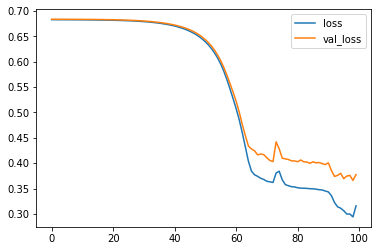

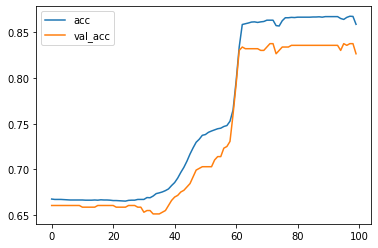

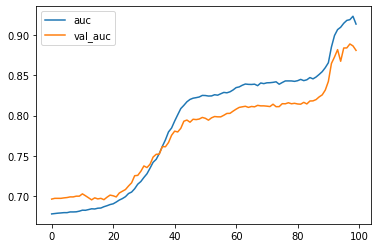

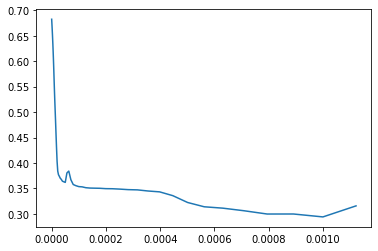

5416/5416 [==============================] - 2s 367us/sample - loss: 0.3228 - tp: 1376.0000 - fp: 0.0000e+00 - tn: 3286.0000 - fn: 754.0000 - accuracy: 0.8608 - precision: 1.0000 - recall: 0.6460 - auc: 0.9062
Training model...
Train on 4874 samples, validate on 542 samples
Epoch 1/100
4874/4874 [==============================] - 6s 1ms/sample - loss: 0.6861 - tp: 942.0000 - fp: 575.0000 - tn: 2391.0000 - fn: 966.0000 - accuracy: 0.6838 - precision: 0.6210 - recall: 0.4937 - auc: 0.7093 - val_loss: 0.6857 - val_tp: 115.0000 - val_fp: 62.0000 - val_tn: 258.0000 - val_fn: 107.0000 - val_accuracy: 0.6882 - val_precision: 0.6497 - val_recall: 0.5180 - val_auc: 0.7099
Epoch 2/100
4874/4874 [==============================] - 3s 659us/sample - loss: 0.6861 - tp: 941.0000 - fp: 573.0000 - tn: 2393.0000 - fn: 967.0000 - accuracy: 0.6840 - precision: 0.6215 - recall: 0.4932 - auc: 0.7101 - val_loss: 0.6857 - val_tp: 115.0000 - val_fp: 62.0000 - val_tn: 258.0000 - val_fn: 107.0000 - val_accuracy:

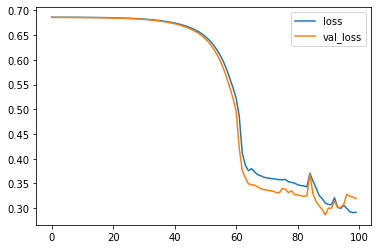

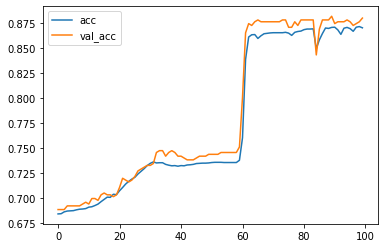

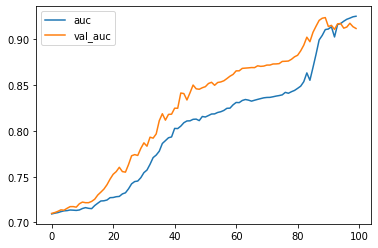

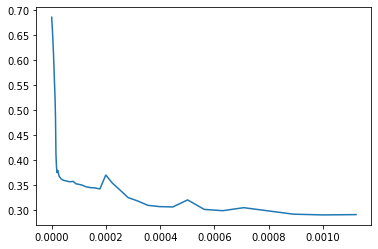

5415/5415 [==============================] - 2s 374us/sample - loss: 0.3076 - tp: 1417.0000 - fp: 22.0000 - tn: 3263.0000 - fn: 713.0000 - accuracy: 0.8643 - precision: 0.9847 - recall: 0.6653 - auc: 0.9171


In [48]:
# some configuration
VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 100   # number of complete passes through the training dataset
#LEARNING_RATE = 0.001
N_SPLITS = 2
from keras.callbacks import LearningRateScheduler

print('Building Bi-LSTM model...')
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state = 7)
cvscores = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'auc', 'learning_rate'])
labels = data_cleaned['relevance'].values
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

sd=[]
# define loss history to record losses while changing learning rate

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = [1,1]

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        sd.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))

for train, test in kfold.split(texts, labels):

  model = tf.keras.Sequential([
       tf.keras.layers.Embedding(num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False),
       tf.keras.layers.LSTM(32, return_sequences=True),
       tf.keras.layers.GlobalAveragePooling1D(),
       tf.keras.layers.Dense(32, activation='relu'),
       tf.keras.layers.Dense(1, activation='sigmoid')
  ])


  optimizer = tf.keras.optimizers.Adam(lr=1e-8)
  model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizer,
    metrics = METRICS,
  
  )

  # learning rate will change from 1e-7 to 1e-3
  def step_decay(losses):
          lrate=1e-8 * 10**(len(history.losses) / 20)
          momentum=0.8
          decay_rate=2e-6
          return lrate

  history=LossHistory()
  lrate=LearningRateScheduler(step_decay)

# Training model:

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

  print('Training model...')
  r = model.fit(
    texts[train],
    labels[train],
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    callbacks=[history, lrate]
  )



  model.summary()

# plot some data
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

# accuracies
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.legend()
  plt.show()

# auc
  plt.plot(r.history['auc'], label='auc')
  plt.plot(r.history['val_auc'], label='val_auc')
  plt.legend()
  plt.show()

# lr
  plt.plot(r.history['lr'], r.history['loss'])
  plt.show()

  #scores = saved_model.evaluate(x = texts[test], y = labels[test])
  scores = model.evaluate(x = texts[test], y = labels[test])
  idx = r.history['loss'].index(min(r.history['loss'])) # select the learning rate with lowest loss
  cvscores = cvscores.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 'auc': scores[8], 'learning_rate': r.history['lr'][idx]}, ignore_index=True)

In [49]:
cvscores

tp    fp      tn     fn  ...  precision    recall       auc  learning_rate
0  1376.0   0.0  3286.0  754.0  ...   1.000000  0.646009  0.906220          0.001
1  1417.0  22.0  3263.0  713.0  ...   0.984712  0.665258  0.917055          0.001

[2 rows x 9 columns]

In [50]:
cvscores.mean(axis = 0)

tp               1396.500000
fp                 11.000000
tn               3274.500000
fn                733.500000
accuracy            0.862524
precision           0.992356
recall              0.655634
auc                 0.911637
learning_rate       0.001000
dtype: float64

##### LSTM_method 2 (1e-5/0.00001)

In [0]:
labels = data_cleaned['relevance'].values
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.1, random_state=7)

In [0]:
from matplotlib import pyplot


In [0]:
def fit_model(trainX, trainy, testX, testy, lrate, cvscores_t):
  VALIDATION_SPLIT = 0.1   
  BATCH_SIZE = 32   # number of training samples to work through
  EPOCHS = 100   # number of complete passes through the training dataset
  
  print('Building LSTM model...')


  METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
  ]


  model = tf.keras.Sequential([
       tf.keras.layers.Embedding(num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=True),
       tf.keras.layers.LSTM(32, return_sequences=True),
       tf.keras.layers.GlobalAveragePooling1D(),
       tf.keras.layers.Dense(32, activation='relu'),
       tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  
  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = lrate),
    metrics = METRICS,
  
  )


  print('Training model...')
  r = model.fit(
    trainX,
    trainy,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    verbose = 0

  )

  print('learning rate', lrate)
# plot some data
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

# accuracies
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.legend()
  plt.show()

# auc
  plt.plot(r.history['auc'], label='auc')
  plt.plot(r.history['val_auc'], label='val_auc')
  plt.legend()
  plt.show()



  #scores = saved_model.evaluate(x = texts[test], y = labels[test])
  scores = model.evaluate(x = testX, y = testy)
  y_pred = model.predict(x=testX)
  y_pred = K.round(y_pred)
  ck = cohen_kappa_score(testy, y_pred)
  cvscores_t = cvscores_t.append({'learning rate': lrate, 'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 
                              'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 
                              'f1': 2 * (scores[6] * scores[7]) / (scores[6] + scores[7]),'auc': scores[8],
                              'cohen-kappa-score': ck}, ignore_index=True)
  return cvscores_t

In [0]:
# create learning curves for different learning rates
learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
cvscores_t = pd.DataFrame(columns = ['learning_rate','tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen-kappa-score'])


Building LSTM model...
Training model...
learning rate 1.0


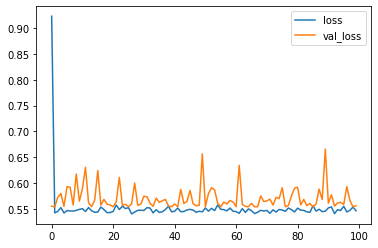

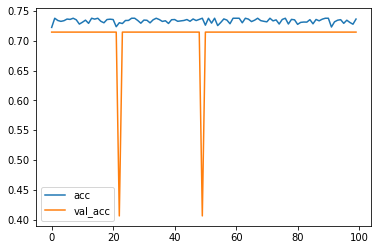

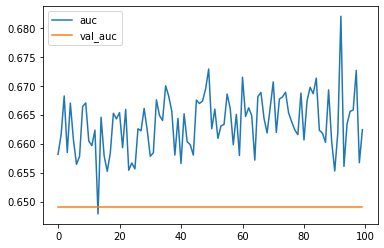

1084/1084 [==============================] - 0s 369us/sample - loss: 0.5244 - tp: 156.0000 - fp: 0.0000e+00 - tn: 648.0000 - fn: 280.0000 - accuracy: 0.7417 - precision: 1.0000 - recall: 0.3578 - auc: 0.6789
Building LSTM model...
Training model...
learning rate 0.1


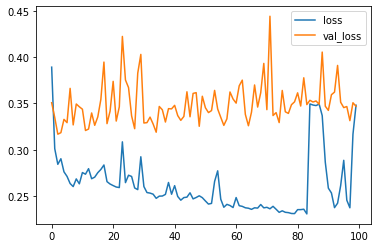

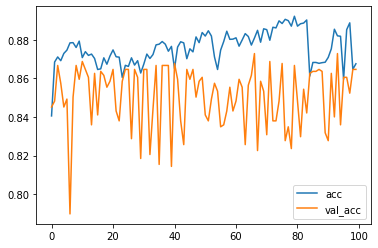

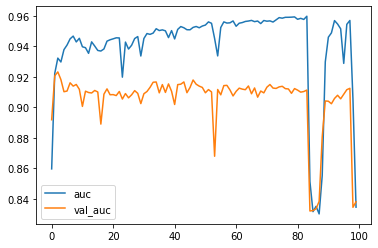

1084/1084 [==============================] - 0s 371us/sample - loss: 0.3234 - tp: 304.0000 - fp: 0.0000e+00 - tn: 648.0000 - fn: 132.0000 - accuracy: 0.8782 - precision: 1.0000 - recall: 0.6972 - auc: 0.8574
Building LSTM model...
Training model...
learning rate 0.01


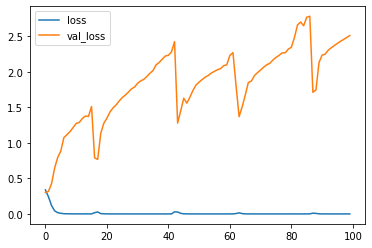

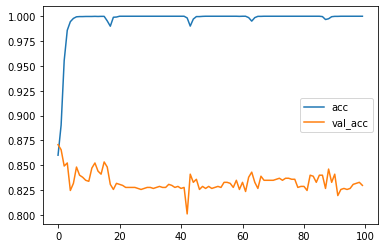

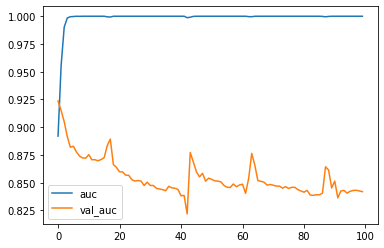

1084/1084 [==============================] - 0s 385us/sample - loss: 2.3335 - tp: 336.0000 - fp: 84.0000 - tn: 564.0000 - fn: 100.0000 - accuracy: 0.8303 - precision: 0.8000 - recall: 0.7706 - auc: 0.8505
Building LSTM model...
Training model...
learning rate 0.001


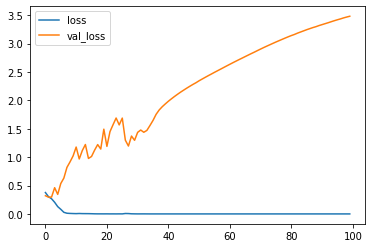

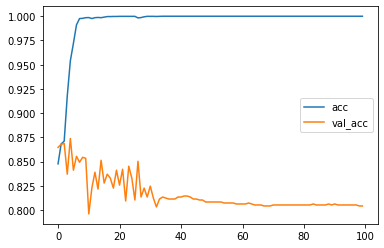

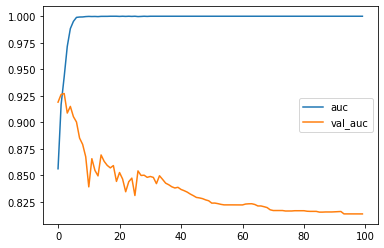

1084/1084 [==============================] - 0s 377us/sample - loss: 3.6917 - tp: 351.0000 - fp: 130.0000 - tn: 518.0000 - fn: 85.0000 - accuracy: 0.8017 - precision: 0.7297 - recall: 0.8050 - auc: 0.8090
Building LSTM model...
Training model...
learning rate 0.0001


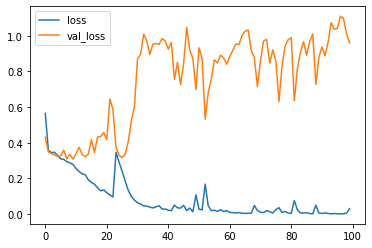

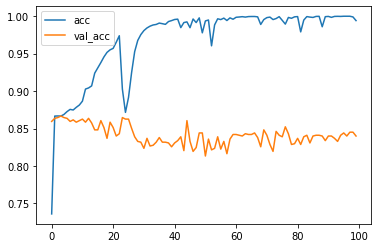

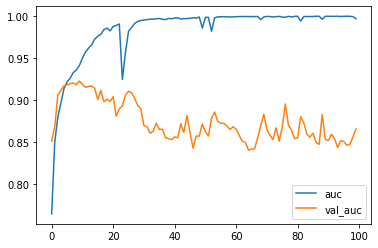

1084/1084 [==============================] - 0s 371us/sample - loss: 0.9562 - tp: 344.0000 - fp: 85.0000 - tn: 563.0000 - fn: 92.0000 - accuracy: 0.8367 - precision: 0.8019 - recall: 0.7890 - auc: 0.8619
Building LSTM model...
Training model...
learning rate 1e-05


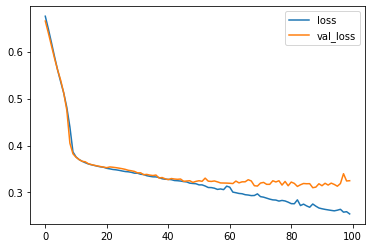

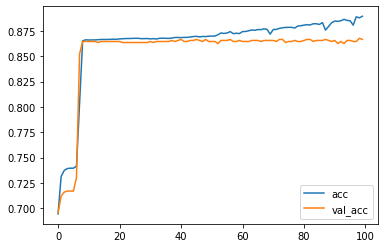

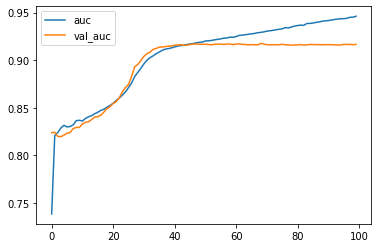

1084/1084 [==============================] - 0s 382us/sample - loss: 0.3196 - tp: 317.0000 - fp: 17.0000 - tn: 631.0000 - fn: 119.0000 - accuracy: 0.8745 - precision: 0.9491 - recall: 0.7271 - auc: 0.9247
Building LSTM model...
Training model...
learning rate 1e-06


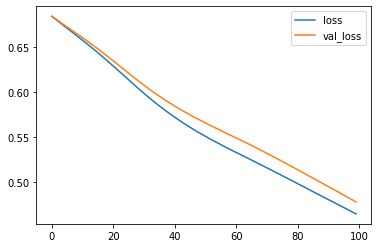

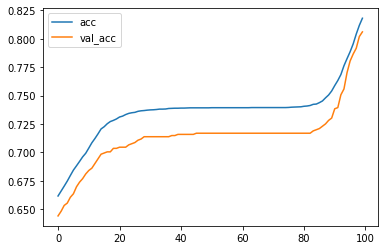

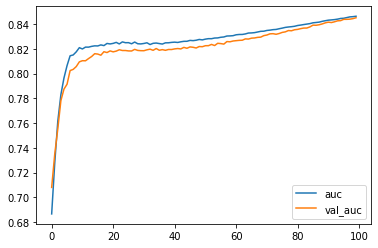

1084/1084 [==============================] - 0s 374us/sample - loss: 0.4541 - tp: 251.0000 - fp: 0.0000e+00 - tn: 648.0000 - fn: 185.0000 - accuracy: 0.8293 - precision: 1.0000 - recall: 0.5757 - auc: 0.8622
Building LSTM model...
Training model...
learning rate 1e-07


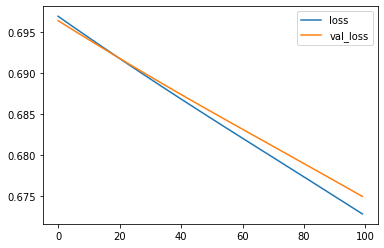

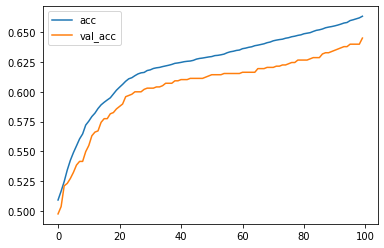

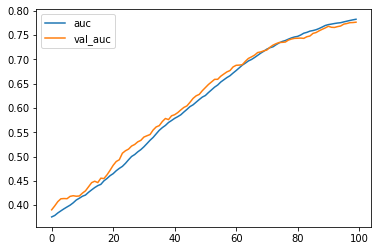

1084/1084 [==============================] - 0s 373us/sample - loss: 0.6735 - tp: 69.0000 - fp: 0.0000e+00 - tn: 648.0000 - fn: 367.0000 - accuracy: 0.6614 - precision: 1.0000 - recall: 0.1583 - auc: 0.7947


In [47]:
for i in range(len(learning_rates)):
# fit model and plot learning curves for a learning rate
 x = fit_model(X_train, y_train, X_test, y_test, learning_rates[i], cvscores_t)
 cvscores_t = cvscores_t.append(x)

#### Learning rate 0.001

##### LSTM

Building Bi-LSTM model...
Training model...
Train on 8772 samples, validate on 975 samples
Epoch 1/100
8772/8772 [==============================] - 26s 3ms/sample - loss: 0.3717 - tp: 2121.0000 - fp: 34.0000 - tn: 5306.0000 - fn: 1311.0000 - accuracy: 0.8467 - precision: 0.9842 - recall: 0.6180 - auc: 0.8729 - val_loss: 0.3340 - val_tp: 265.0000 - val_fp: 0.0000e+00 - val_tn: 573.0000 - val_fn: 137.0000 - val_accuracy: 0.8595 - val_precision: 1.0000 - val_recall: 0.6592 - val_auc: 0.9078
Epoch 2/100
8772/8772 [==============================] - 23s 3ms/sample - loss: 0.2893 - tp: 2354.0000 - fp: 48.0000 - tn: 5292.0000 - fn: 1078.0000 - accuracy: 0.8716 - precision: 0.9800 - recall: 0.6859 - auc: 0.9292 - val_loss: 0.3527 - val_tp: 329.0000 - val_fp: 99.0000 - val_tn: 474.0000 - val_fn: 73.0000 - val_accuracy: 0.8236 - val_precision: 0.7687 - val_recall: 0.8184 - val_auc: 0.9138
Epoch 3/100
8772/8772 [==============================] - 23s 3ms/sample - loss: 0.2382 - tp: 2800.0000 - fp: 

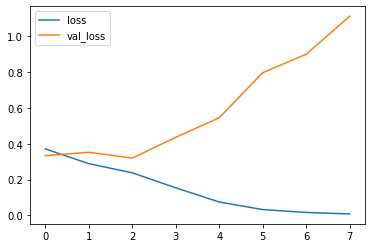

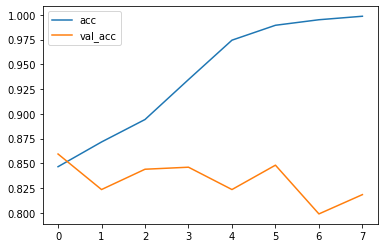

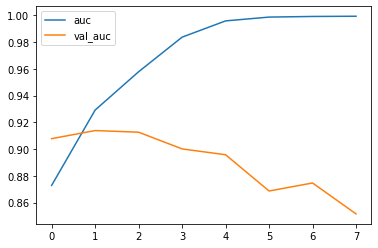

1084/1084 [==============================] - 0s 391us/sample - loss: 0.3250 - tp: 316.0000 - fp: 46.0000 - tn: 612.0000 - fn: 110.0000 - accuracy: 0.8561 - precision: 0.8729 - recall: 0.7418 - auc: 0.9084
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 26s 3ms/sample - loss: 0.3738 - tp: 2142.0000 - fp: 40.0000 - tn: 5304.0000 - fn: 1287.0000 - accuracy: 0.8487 - precision: 0.9817 - recall: 0.6247 - auc: 0.8605 - val_loss: 0.3321 - val_tp: 265.0000 - val_fp: 0.0000e+00 - val_tn: 570.0000 - val_fn: 140.0000 - val_accuracy: 0.8564 - val_precision: 1.0000 - val_recall: 0.6543 - val_auc: 0.9050
Epoch 2/100
8773/8773 [==============================] - 23s 3ms/sample - loss: 0.2970 - tp: 2312.0000 - fp: 31.0000 - tn: 5313.0000 - fn: 1117.0000 - accuracy: 0.8691 - precision: 0.9868 - recall: 0.6742 - auc: 0.9225 - val_loss: 0.3213 - val_tp: 271.0000 - val_fp: 5.0000 - val_tn: 565.0000 - val_fn: 134.0000 - val_accuracy: 

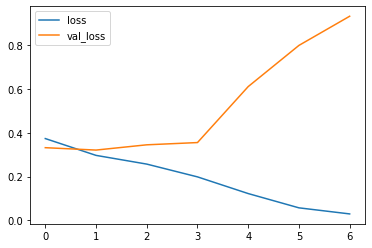

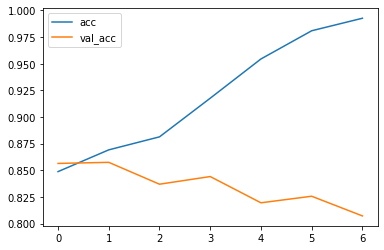

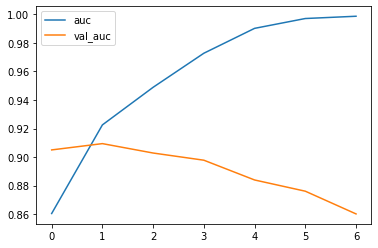

1083/1083 [==============================] - 0s 384us/sample - loss: 0.3084 - tp: 302.0000 - fp: 12.0000 - tn: 645.0000 - fn: 124.0000 - accuracy: 0.8744 - precision: 0.9618 - recall: 0.7089 - auc: 0.9235
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 26s 3ms/sample - loss: 0.3741 - tp: 2118.0000 - fp: 11.0000 - tn: 5329.0000 - fn: 1315.0000 - accuracy: 0.8489 - precision: 0.9948 - recall: 0.6170 - auc: 0.8625 - val_loss: 0.3309 - val_tp: 264.0000 - val_fp: 0.0000e+00 - val_tn: 574.0000 - val_fn: 137.0000 - val_accuracy: 0.8595 - val_precision: 1.0000 - val_recall: 0.6584 - val_auc: 0.9033
Epoch 2/100
8773/8773 [==============================] - 23s 3ms/sample - loss: 0.3084 - tp: 2308.0000 - fp: 42.0000 - tn: 5298.0000 - fn: 1125.0000 - accuracy: 0.8670 - precision: 0.9821 - recall: 0.6723 - auc: 0.9122 - val_loss: 0.3273 - val_tp: 264.0000 - val_fp: 0.0000e+00 - val_tn: 574.0000 - val_fn: 137.0000 - val_accura

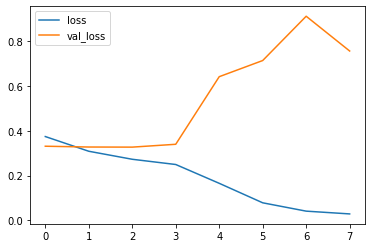

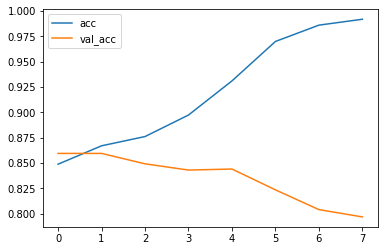

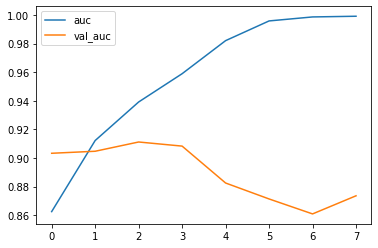

1083/1083 [==============================] - 0s 389us/sample - loss: 0.2860 - tp: 306.0000 - fp: 22.0000 - tn: 635.0000 - fn: 120.0000 - accuracy: 0.8689 - precision: 0.9329 - recall: 0.7183 - auc: 0.9313
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 26s 3ms/sample - loss: 0.3859 - tp: 2115.0000 - fp: 33.0000 - tn: 5310.0000 - fn: 1315.0000 - accuracy: 0.8463 - precision: 0.9846 - recall: 0.6166 - auc: 0.8518 - val_loss: 0.3372 - val_tp: 265.0000 - val_fp: 0.0000e+00 - val_tn: 571.0000 - val_fn: 139.0000 - val_accuracy: 0.8574 - val_precision: 1.0000 - val_recall: 0.6559 - val_auc: 0.9047
Epoch 2/100
8773/8773 [==============================] - 23s 3ms/sample - loss: 0.3065 - tp: 2290.0000 - fp: 1.0000 - tn: 5342.0000 - fn: 1140.0000 - accuracy: 0.8699 - precision: 0.9996 - recall: 0.6676 - auc: 0.9115 - val_loss: 0.3289 - val_tp: 264.0000 - val_fp: 0.0000e+00 - val_tn: 571.0000 - val_fn: 140.0000 - val_accurac

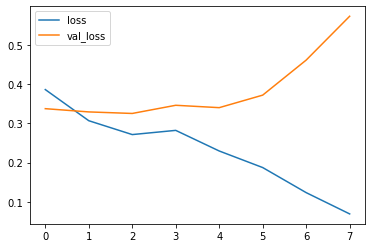

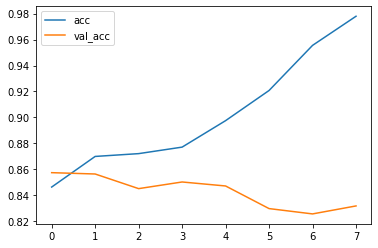

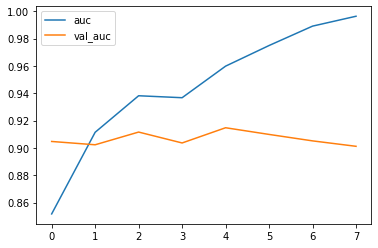

1083/1083 [==============================] - 0s 402us/sample - loss: 0.3288 - tp: 334.0000 - fp: 69.0000 - tn: 588.0000 - fn: 92.0000 - accuracy: 0.8513 - precision: 0.8288 - recall: 0.7840 - auc: 0.9053
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 26s 3ms/sample - loss: 0.3840 - tp: 2114.0000 - fp: 41.0000 - tn: 5297.0000 - fn: 1321.0000 - accuracy: 0.8448 - precision: 0.9810 - recall: 0.6154 - auc: 0.8593 - val_loss: 0.3282 - val_tp: 262.0000 - val_fp: 0.0000e+00 - val_tn: 576.0000 - val_fn: 137.0000 - val_accuracy: 0.8595 - val_precision: 1.0000 - val_recall: 0.6566 - val_auc: 0.9068
Epoch 2/100
8773/8773 [==============================] - 24s 3ms/sample - loss: 0.3019 - tp: 2323.0000 - fp: 43.0000 - tn: 5295.0000 - fn: 1112.0000 - accuracy: 0.8683 - precision: 0.9818 - recall: 0.6763 - auc: 0.9197 - val_loss: 0.3274 - val_tp: 265.0000 - val_fp: 3.0000 - val_tn: 573.0000 - val_fn: 134.0000 - val_accuracy: 0

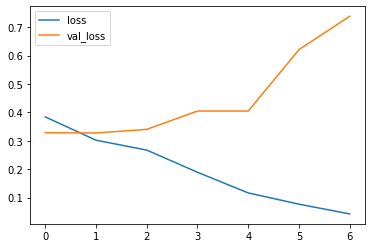

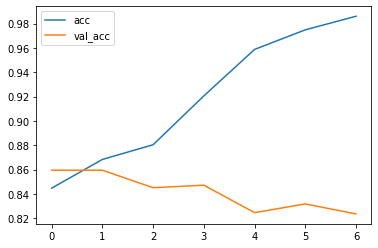

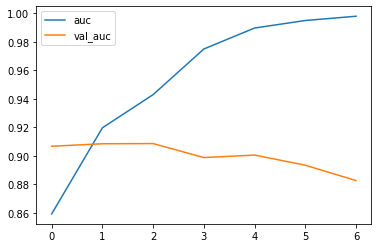

1083/1083 [==============================] - 0s 374us/sample - loss: 0.2868 - tp: 307.0000 - fp: 7.0000 - tn: 650.0000 - fn: 119.0000 - accuracy: 0.8837 - precision: 0.9777 - recall: 0.7207 - auc: 0.9267
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 30s 3ms/sample - loss: 0.3843 - tp: 2146.0000 - fp: 82.0000 - tn: 5253.0000 - fn: 1292.0000 - accuracy: 0.8434 - precision: 0.9632 - recall: 0.6242 - auc: 0.8494 - val_loss: 0.3386 - val_tp: 261.0000 - val_fp: 0.0000e+00 - val_tn: 579.0000 - val_fn: 135.0000 - val_accuracy: 0.8615 - val_precision: 1.0000 - val_recall: 0.6591 - val_auc: 0.9066
Epoch 2/100
8773/8773 [==============================] - 24s 3ms/sample - loss: 0.3057 - tp: 2318.0000 - fp: 14.0000 - tn: 5321.0000 - fn: 1120.0000 - accuracy: 0.8707 - precision: 0.9940 - recall: 0.6742 - auc: 0.9155 - val_loss: 0.3112 - val_tp: 264.0000 - val_fp: 1.0000 - val_tn: 578.0000 - val_fn: 132.0000 - val_accuracy: 0

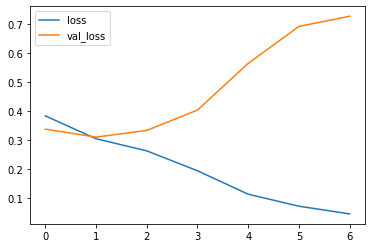

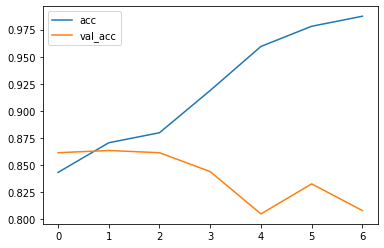

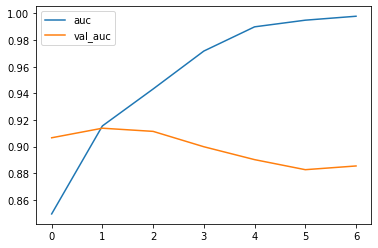

1083/1083 [==============================] - 0s 374us/sample - loss: 0.3286 - tp: 272.0000 - fp: 2.0000 - tn: 655.0000 - fn: 154.0000 - accuracy: 0.8560 - precision: 0.9927 - recall: 0.6385 - auc: 0.9027
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 27s 3ms/sample - loss: 0.3744 - tp: 2136.0000 - fp: 35.0000 - tn: 5302.0000 - fn: 1300.0000 - accuracy: 0.8478 - precision: 0.9839 - recall: 0.6217 - auc: 0.8613 - val_loss: 0.3184 - val_tp: 262.0000 - val_fp: 0.0000e+00 - val_tn: 577.0000 - val_fn: 136.0000 - val_accuracy: 0.8605 - val_precision: 1.0000 - val_recall: 0.6583 - val_auc: 0.9109
Epoch 2/100
8773/8773 [==============================] - 23s 3ms/sample - loss: 0.3006 - tp: 2280.0000 - fp: 2.0000 - tn: 5335.0000 - fn: 1156.0000 - accuracy: 0.8680 - precision: 0.9991 - recall: 0.6636 - auc: 0.9185 - val_loss: 0.3120 - val_tp: 267.0000 - val_fp: 0.0000e+00 - val_tn: 577.0000 - val_fn: 131.0000 - val_accuracy

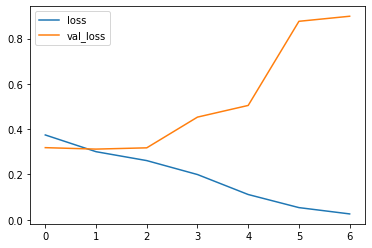

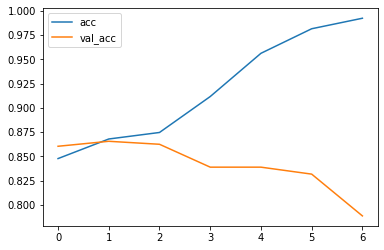

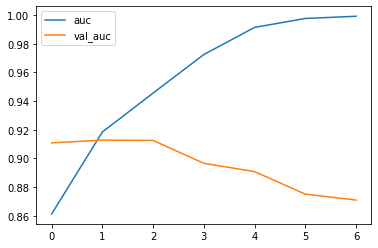

1083/1083 [==============================] - 0s 375us/sample - loss: 0.2720 - tp: 291.0000 - fp: 0.0000e+00 - tn: 657.0000 - fn: 135.0000 - accuracy: 0.8753 - precision: 1.0000 - recall: 0.6831 - auc: 0.9357
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 26s 3ms/sample - loss: 0.3848 - tp: 2072.0000 - fp: 14.0000 - tn: 5329.0000 - fn: 1358.0000 - accuracy: 0.8436 - precision: 0.9933 - recall: 0.6041 - auc: 0.8603 - val_loss: 0.3193 - val_tp: 267.0000 - val_fp: 0.0000e+00 - val_tn: 571.0000 - val_fn: 137.0000 - val_accuracy: 0.8595 - val_precision: 1.0000 - val_recall: 0.6609 - val_auc: 0.9101
Epoch 2/100
8773/8773 [==============================] - 24s 3ms/sample - loss: 0.2928 - tp: 2317.0000 - fp: 48.0000 - tn: 5295.0000 - fn: 1113.0000 - accuracy: 0.8677 - precision: 0.9797 - recall: 0.6755 - auc: 0.9245 - val_loss: 0.3230 - val_tp: 288.0000 - val_fp: 36.0000 - val_tn: 535.0000 - val_fn: 116.0000 - val_accura

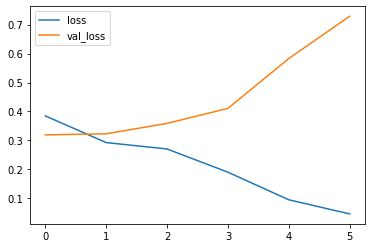

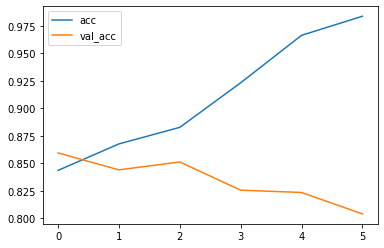

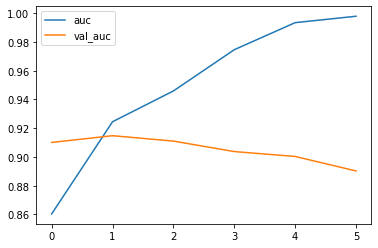

1083/1083 [==============================] - 0s 429us/sample - loss: 0.3005 - tp: 289.0000 - fp: 0.0000e+00 - tn: 657.0000 - fn: 137.0000 - accuracy: 0.8735 - precision: 1.0000 - recall: 0.6784 - auc: 0.9188
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 27s 3ms/sample - loss: 0.3799 - tp: 2131.0000 - fp: 58.0000 - tn: 5278.0000 - fn: 1306.0000 - accuracy: 0.8445 - precision: 0.9735 - recall: 0.6200 - auc: 0.8571 - val_loss: 0.3155 - val_tp: 267.0000 - val_fp: 0.0000e+00 - val_tn: 578.0000 - val_fn: 130.0000 - val_accuracy: 0.8667 - val_precision: 1.0000 - val_recall: 0.6725 - val_auc: 0.9126
Epoch 2/100
8773/8773 [==============================] - 22s 3ms/sample - loss: 0.2976 - tp: 2293.0000 - fp: 7.0000 - tn: 5329.0000 - fn: 1144.0000 - accuracy: 0.8688 - precision: 0.9970 - recall: 0.6672 - auc: 0.9213 - val_loss: 0.3168 - val_tp: 266.0000 - val_fp: 0.0000e+00 - val_tn: 578.0000 - val_fn: 131.0000 - val_accu

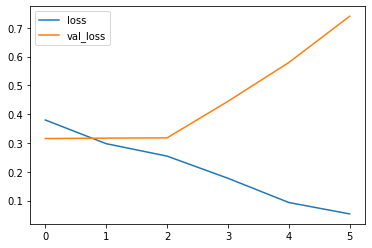

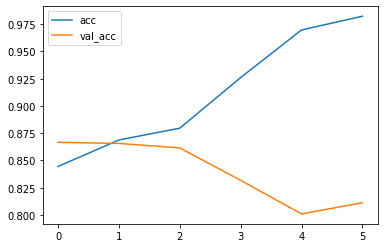

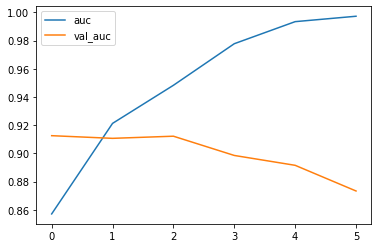

1083/1083 [==============================] - 0s 387us/sample - loss: 0.3183 - tp: 280.0000 - fp: 0.0000e+00 - tn: 657.0000 - fn: 146.0000 - accuracy: 0.8652 - precision: 1.0000 - recall: 0.6573 - auc: 0.9126
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 26s 3ms/sample - loss: 0.3863 - tp: 2117.0000 - fp: 18.0000 - tn: 5330.0000 - fn: 1308.0000 - accuracy: 0.8489 - precision: 0.9916 - recall: 0.6181 - auc: 0.8495 - val_loss: 0.3431 - val_tp: 275.0000 - val_fp: 0.0000e+00 - val_tn: 566.0000 - val_fn: 134.0000 - val_accuracy: 0.8626 - val_precision: 1.0000 - val_recall: 0.6724 - val_auc: 0.8907
Epoch 2/100
8773/8773 [==============================] - 25s 3ms/sample - loss: 0.3032 - tp: 2324.0000 - fp: 31.0000 - tn: 5317.0000 - fn: 1101.0000 - accuracy: 0.8710 - precision: 0.9868 - recall: 0.6785 - auc: 0.9161 - val_loss: 0.3100 - val_tp: 284.0000 - val_fp: 15.0000 - val_tn: 551.0000 - val_fn: 125.0000 - val_accura

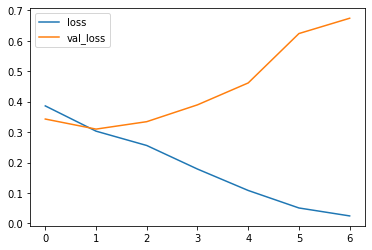

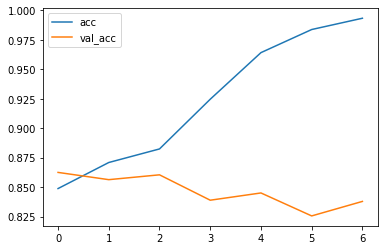

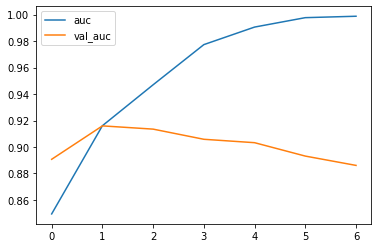

1083/1083 [==============================] - 0s 380us/sample - loss: 0.3077 - tp: 283.0000 - fp: 8.0000 - tn: 649.0000 - fn: 143.0000 - accuracy: 0.8606 - precision: 0.9725 - recall: 0.6643 - auc: 0.9167


In [125]:
# some configuration
VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 100   # number of complete passes through the training dataset
LEARNING_RATE = 0.001
N_SPLITS = 10


print('Building Bi-LSTM model...')
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state = 7)
cvscores_lstm = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen-kappa-score'])
labels = data_cleaned['relevance'].values
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]


for train, test in kfold.split(texts, labels):

  model = tf.keras.Sequential([
       tf.keras.layers.Embedding(num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=True),
       tf.keras.layers.LSTM(32, return_sequences=True),
       #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
       #tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, padding='valid', activation='relu', strides=1),
       #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
       tf.keras.layers.GlobalAveragePooling1D(),
       tf.keras.layers.Dense(32, activation='relu'),
       tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  
  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = METRICS,
  
  )



# Training model:

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
#  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
# fit model
# load a saved model

#  from sklearn.utils import class_weight

  print('Training model...')
  r = model.fit(
    texts[train],
    labels[train],
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    #callbacks=[history, lrate]
    #callbacks=[lr_schedule]
    callbacks=[es]
    #class_weight = class_weight_dict
    #use_multiprocessing=True
  )

#  saved_model = tf.keras.models.load_model('best_model.h5')
#  saved_model.summary()

  model.summary()

# plot some data
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

# accuracies
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.legend()
  plt.show()

# auc
  plt.plot(r.history['auc'], label='auc')
  plt.plot(r.history['val_auc'], label='val_auc')
  plt.legend()
  plt.show()



  #scores = saved_model.evaluate(x = texts[test], y = labels[test])
  scores = model.evaluate(x = texts[test], y = labels[test])
  y_pred = model.predict(x=texts[test])
  y_pred = K.round(y_pred)
  ck = cohen_kappa_score(labels[test], y_pred)
  cvscores_lstm = cvscores_lstm.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 
                              'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 
                              'f1': 2 * (scores[6] * scores[7]) / (scores[6] + scores[7]),'auc': scores[8],
                              'cohen-kappa-score': ck}, ignore_index=True)

In [126]:
cvscores_lstm

tp    fp     tn     fn  ...    recall        f1       auc  cohen-kappa-score
0  316.0  46.0  612.0  110.0  ...  0.741784  0.802030  0.908376           0.690154
1  302.0  12.0  645.0  124.0  ...  0.708920  0.816216  0.923548           0.724124
2  306.0  22.0  635.0  120.0  ...  0.718310  0.811671  0.931294           0.713687
3  334.0  69.0  588.0   92.0  ...  0.784038  0.805790  0.905280           0.685521
4  307.0   7.0  650.0  119.0  ...  0.720657  0.829730  0.926742           0.744409
5  272.0   2.0  655.0  154.0  ...  0.638498  0.777143  0.902734           0.677981
6  291.0   0.0  657.0  135.0  ...  0.683099  0.811716  0.935732           0.723400
7  289.0   0.0  657.0  137.0  ...  0.678404  0.808392  0.918757           0.719057
8  280.0   0.0  657.0  146.0  ...  0.657277  0.793201  0.912638           0.699417
9  283.0   8.0  649.0  143.0  ...  0.664319  0.789400  0.916735           0.690618

[10 rows x 10 columns]

In [127]:
cvscores_lstm.mean()

tp                   298.000000
fp                    16.600000
tn                   640.500000
fn                   128.000000
accuracy               0.866495
precision              0.953934
recall                 0.699531
f1                     0.804529
auc                    0.918184
cohen-kappa-score      0.706837
dtype: float64

In [0]:
cvscores_lstm.to_csv("/gdrive/My Drive/lstm.csv")

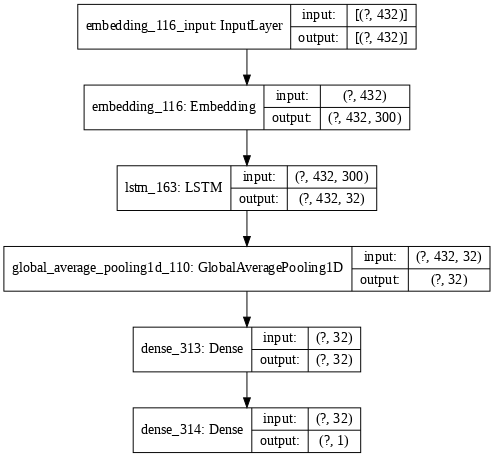

In [129]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot_lstm_tf.png', show_shapes=True, show_layer_names=True, dpi = 70)

##### LSTM + tf-idf (concatenate)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
# calculate Tfidf vector
word_vectorizer = TfidfVectorizer(
    max_features=500)

word_vectorizer.fit(data_cleaned['texts'])
tf_idf = word_vectorizer.transform(data_cleaned['texts'])
tf_idf = tf_idf.toarray()

In [0]:
texts_tf= np.concatenate([texts, tf_idf], axis = 1)  # concatenate word embedding and Tfidf vectors

In [57]:
texts_tf

array([[8.0000e+00, 1.0000e+00, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.2080e+03, 9.5140e+03, 1.6540e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0100e+02, 9.0000e+00, 4.9000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.6700e+02, 3.6400e+02, 1.3350e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.4800e+02, 2.2200e+02, 1.0600e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.2409e+04, 4.2900e+02, 2.4440e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

Building Bi-LSTM model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 432, 300)     12867900    input_1[0][0]                    
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 500)          1000        input_2[0][0]                    
____________________________________________________________________

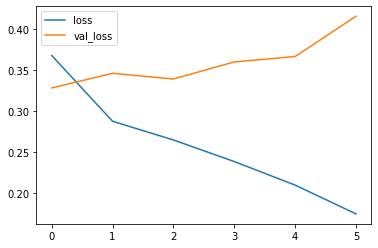

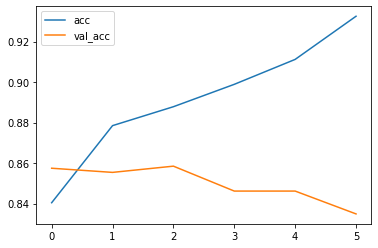

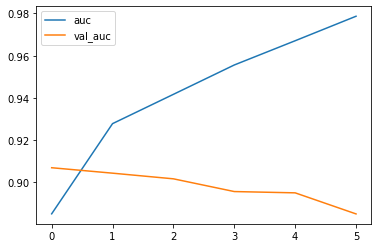

1084/1084 [==============================] - 0s 399us/sample - loss: 0.3531 - tp: 271.0000 - fp: 11.0000 - tn: 647.0000 - fn: 155.0000 - accuracy: 0.8469 - precision: 0.9610 - recall: 0.6362 - auc: 0.8917
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 432, 300)     12867900    input_3[0][0]                    
_____________________________________________________________________________________

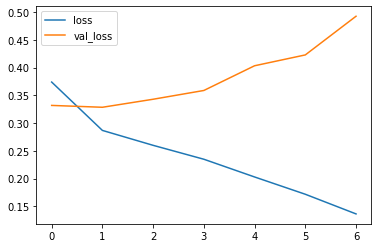

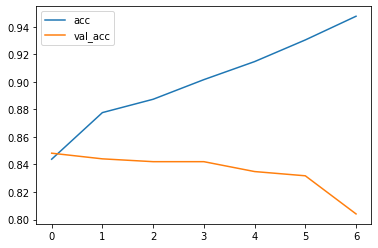

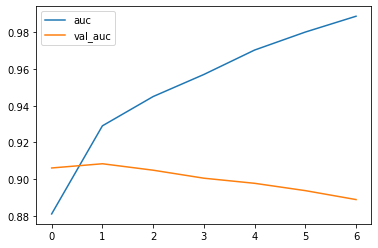

1083/1083 [==============================] - 0s 390us/sample - loss: 0.3290 - tp: 281.0000 - fp: 15.0000 - tn: 642.0000 - fn: 145.0000 - accuracy: 0.8523 - precision: 0.9493 - recall: 0.6596 - auc: 0.9022
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 432, 300)     12867900    input_5[0][0]                    
_____________________________________________________________________________________

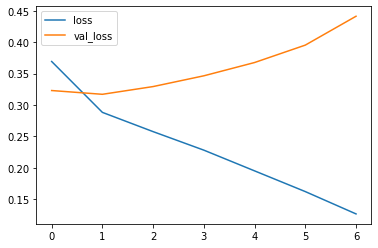

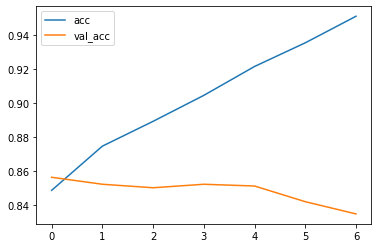

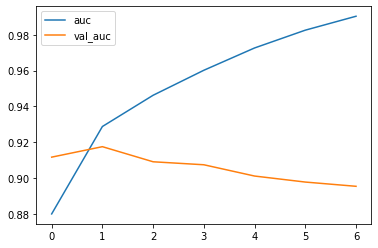

1083/1083 [==============================] - 0s 415us/sample - loss: 0.3347 - tp: 308.0000 - fp: 40.0000 - tn: 617.0000 - fn: 118.0000 - accuracy: 0.8541 - precision: 0.8851 - recall: 0.7230 - auc: 0.8986
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 432, 300)     12867900    input_7[0][0]                    
_____________________________________________________________________________________

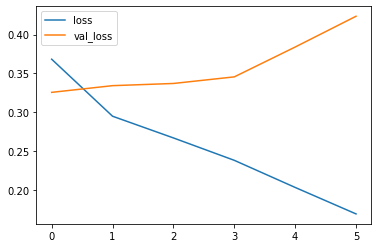

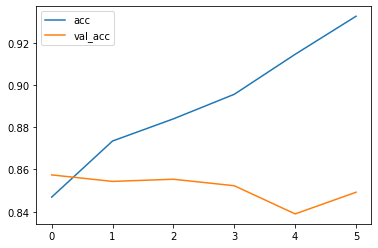

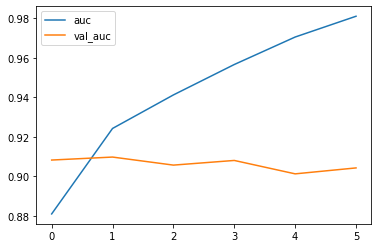

1083/1083 [==============================] - 0s 390us/sample - loss: 0.2853 - tp: 304.0000 - fp: 7.0000 - tn: 650.0000 - fn: 122.0000 - accuracy: 0.8809 - precision: 0.9775 - recall: 0.7136 - auc: 0.9308
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 432, 300)     12867900    input_9[0][0]                    
______________________________________________________________________________________

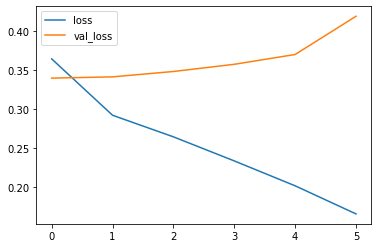

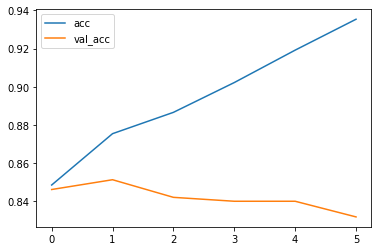

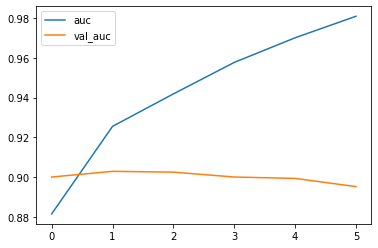

1083/1083 [==============================] - 0s 394us/sample - loss: 0.2985 - tp: 311.0000 - fp: 18.0000 - tn: 639.0000 - fn: 115.0000 - accuracy: 0.8772 - precision: 0.9453 - recall: 0.7300 - auc: 0.9156
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 432, 300)     12867900    input_11[0][0]                   
_____________________________________________________________________________________

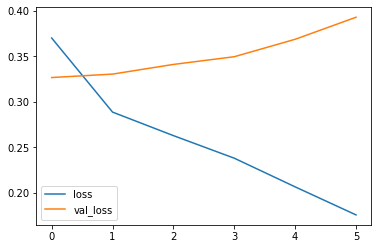

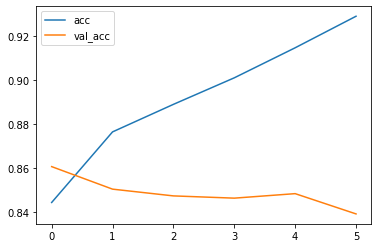

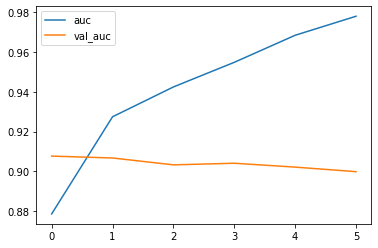

1083/1083 [==============================] - 0s 369us/sample - loss: 0.3156 - tp: 284.0000 - fp: 4.0000 - tn: 653.0000 - fn: 142.0000 - accuracy: 0.8652 - precision: 0.9861 - recall: 0.6667 - auc: 0.9113
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 432, 300)     12867900    input_13[0][0]                   
______________________________________________________________________________________

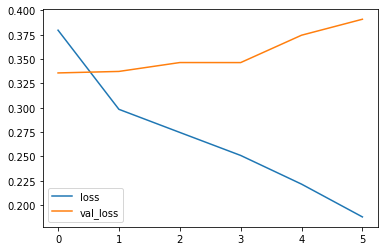

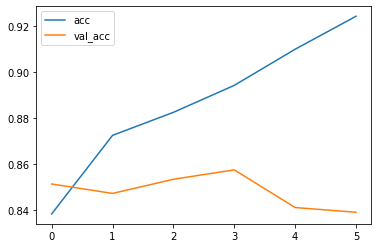

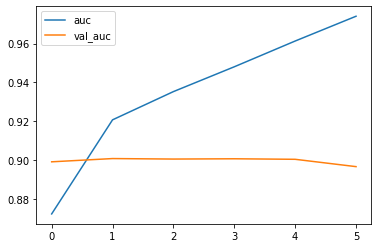

1083/1083 [==============================] - 0s 390us/sample - loss: 0.3004 - tp: 309.0000 - fp: 12.0000 - tn: 645.0000 - fn: 117.0000 - accuracy: 0.8809 - precision: 0.9626 - recall: 0.7254 - auc: 0.9141
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 432, 300)     12867900    input_15[0][0]                   
_____________________________________________________________________________________

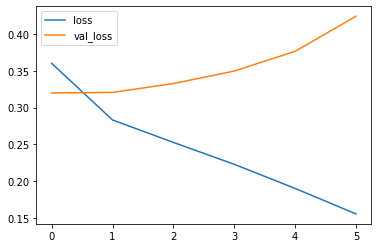

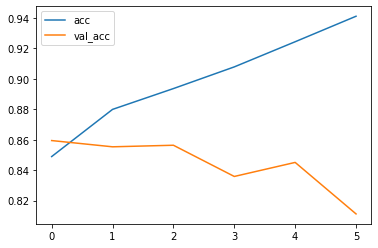

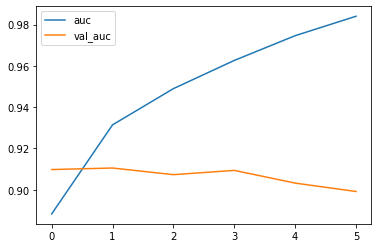

1083/1083 [==============================] - 0s 393us/sample - loss: 0.3544 - tp: 275.0000 - fp: 16.0000 - tn: 641.0000 - fn: 151.0000 - accuracy: 0.8458 - precision: 0.9450 - recall: 0.6455 - auc: 0.8876
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 432, 300)     12867900    input_17[0][0]                   
_____________________________________________________________________________________

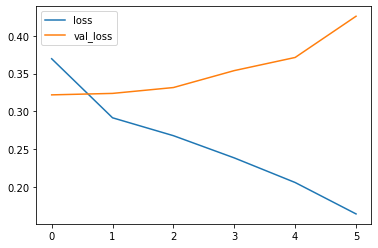

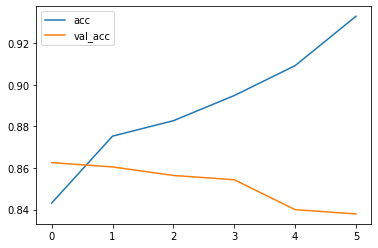

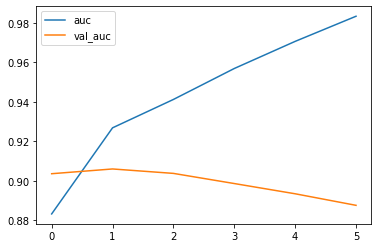

1083/1083 [==============================] - 0s 398us/sample - loss: 0.3116 - tp: 292.0000 - fp: 14.0000 - tn: 643.0000 - fn: 134.0000 - accuracy: 0.8633 - precision: 0.9542 - recall: 0.6854 - auc: 0.9158
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, 432, 300)     12867900    input_19[0][0]                   
_____________________________________________________________________________________

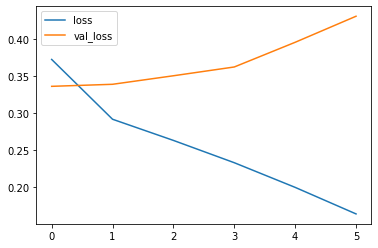

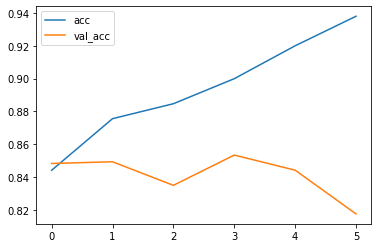

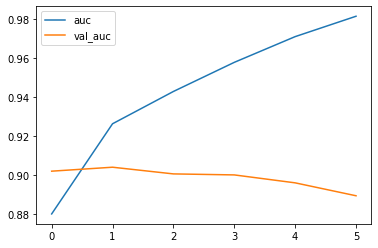

1083/1083 [==============================] - 0s 374us/sample - loss: 0.3056 - tp: 314.0000 - fp: 20.0000 - tn: 637.0000 - fn: 112.0000 - accuracy: 0.8781 - precision: 0.9401 - recall: 0.7371 - auc: 0.9155


In [58]:
# some configuration
VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 100   # number of complete passes through the training dataset
LEARNING_RATE = 0.001
N_SPLITS = 10


print('Building Bi-LSTM model...')
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state = 9)
cvscores_lstm_tf = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen-kappa-score'])
labels = data_cleaned['relevance'].values
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]



embedding_layer = tf.keras.layers.Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=True
)


for train, test in kfold.split(texts_tf, labels):

  x_train = texts_tf[train]
  x_test = texts_tf[test]
  x_train_1 = x_train[:, : MAX_SEQUENCE_LENGTH] # training set for word embeddings using GloVe
  x_train_2 = x_train[:, MAX_SEQUENCE_LENGTH:] # training set for tfidf feature
  x_test_1 = x_test[:, :MAX_SEQUENCE_LENGTH] # testing set for word embedding using GloVe
  x_test_2 = x_test[:, MAX_SEQUENCE_LENGTH:] # testing set for tfidf feature
  y_train = labels[train]
  y_test = labels[test]

  input_1 = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,))  # input layer for word embeddings
  x = embedding_layer(input_1)
  x = tf.keras.layers.LSTM(32)(x)   # LSTM layer on embedding layer
  #x = tf.keras.layers.Dense(16, activation='relu')(x)  

  input_2 = tf.keras.Input(shape=(500,))  # input layer for Tfidf
  tf_vec = tf.keras.layers.LayerNormalization()(input_2)  # tfidf layer
  tf_vec = tf.keras.layers.Dense(32, activation = 'relu')(tf_vec)  # reduce the dimension of Tfidf layer to 32

  concat_layer = tf.keras.layers.Concatenate()([x, tf_vec])  # concatenate LSTM and tfidf layer

  output_vector = tf.keras.layers.Dense(16, activation='relu')(concat_layer)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(output_vector)
  model = tf.keras.models.Model([input_1, input_2], output)
  model.summary()
  
  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = METRICS,
  
  )



# Training model:

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)  # early stopping to avoid overfitting
#  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
# fit model
# load a saved model

#  from sklearn.utils import class_weight

  print('Training model...')
  r = model.fit(
    [x_train_1, x_train_2],
    y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    #callbacks=[history, lrate]
    #callbacks=[lr_schedule]
    callbacks=[es]
    #class_weight = class_weight_dict
    #use_multiprocessing=True
  )

#  saved_model = tf.keras.models.load_model('best_model.h5')
#  saved_model.summary()

  model.summary()

# plot some data
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

# accuracies
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.legend()
  plt.show()

# auc
  plt.plot(r.history['auc'], label='auc')
  plt.plot(r.history['val_auc'], label='val_auc')
  plt.legend()
  plt.show()



  #scores = saved_model.evaluate(x = texts[test], y = labels[test])
  scores = model.evaluate(x = [x_test_1, x_test_2], y = y_test)
  y_pred = model.predict(x=[x_test_1, x_test_2])
  y_pred = K.round(y_pred)
  ck = cohen_kappa_score(labels[test], y_pred)
  cvscores_lstm_tf = cvscores_lstm_tf.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 
                              'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 
                              'f1': 2 * (scores[6] * scores[7]) / (scores[6] + scores[7]),'auc': scores[8],
                              'cohen-kappa-score': ck}, ignore_index=True)

In [59]:
cvscores_lstm_tf

tp    fp     tn     fn  ...    recall        f1       auc  cohen-kappa-score
0  271.0  11.0  647.0  155.0  ...  0.636150  0.765537  0.891732           0.658685
1  281.0  15.0  642.0  145.0  ...  0.659624  0.778393  0.902184           0.672892
2  308.0  40.0  617.0  118.0  ...  0.723005  0.795866  0.898564           0.684143
3  304.0   7.0  650.0  122.0  ...  0.713615  0.824966  0.930839           0.737983
4  311.0  18.0  639.0  115.0  ...  0.730047  0.823841  0.915584           0.731949
5  284.0   4.0  653.0  142.0  ...  0.666667  0.795518  0.911289           0.700469
6  309.0  12.0  645.0  117.0  ...  0.725352  0.827309  0.914103           0.739114
7  275.0  16.0  641.0  151.0  ...  0.645540  0.767085  0.887603           0.657835
8  292.0  14.0  643.0  134.0  ...  0.685446  0.797814  0.915786           0.698739
9  314.0  20.0  637.0  112.0  ...  0.737089  0.826316  0.915482           0.734535

[10 rows x 10 columns]

In [60]:
cvscores_lstm_tf.mean()

tp                   294.900000
fp                    15.700000
tn                   641.400000
fn                   131.100000
accuracy               0.864465
precision              0.950627
recall                 0.692254
f1                     0.800265
auc                    0.908317
cohen-kappa-score      0.701635
dtype: float64

In [0]:
cvscores_lstm_tf.to_csv("/gdrive/My Drive/lstm_tf.csv")

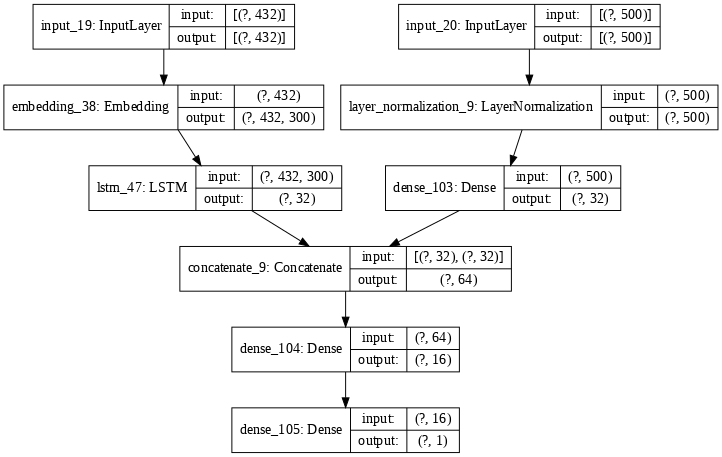

In [61]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot_lstm_tf.png', show_shapes=True, show_layer_names=True, dpi = 70)

##### Bi-LSTM

Building Bi-LSTM model...
Training model...
Train on 8772 samples, validate on 975 samples
Epoch 1/100
8772/8772 [==============================] - 31s 4ms/sample - loss: 0.3577 - tp: 2190.0000 - fp: 66.0000 - tn: 5274.0000 - fn: 1242.0000 - accuracy: 0.8509 - precision: 0.9707 - recall: 0.6381 - auc: 0.8827 - val_loss: 0.3172 - val_tp: 268.0000 - val_fp: 2.0000 - val_tn: 571.0000 - val_fn: 134.0000 - val_accuracy: 0.8605 - val_precision: 0.9926 - val_recall: 0.6667 - val_auc: 0.9133
Epoch 2/100
8772/8772 [==============================] - 28s 3ms/sample - loss: 0.2840 - tp: 2446.0000 - fp: 119.0000 - tn: 5221.0000 - fn: 986.0000 - accuracy: 0.8740 - precision: 0.9536 - recall: 0.7127 - auc: 0.9311 - val_loss: 0.3423 - val_tp: 316.0000 - val_fp: 84.0000 - val_tn: 489.0000 - val_fn: 86.0000 - val_accuracy: 0.8256 - val_precision: 0.7900 - val_recall: 0.7861 - val_auc: 0.9104
Epoch 3/100
8772/8772 [==============================] - 28s 3ms/sample - loss: 0.2423 - tp: 2721.0000 - fp: 231.

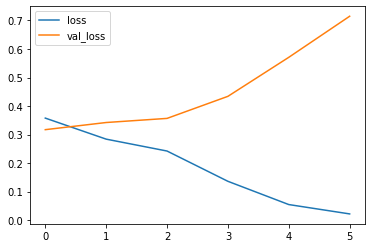

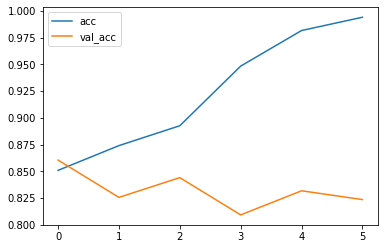

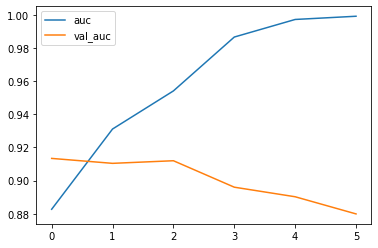

1084/1084 [==============================] - 1s 592us/sample - loss: 0.3231 - tp: 274.0000 - fp: 0.0000e+00 - tn: 658.0000 - fn: 152.0000 - accuracy: 0.8598 - precision: 1.0000 - recall: 0.6432 - auc: 0.9071
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 32s 4ms/sample - loss: 0.3682 - tp: 2168.0000 - fp: 46.0000 - tn: 5298.0000 - fn: 1261.0000 - accuracy: 0.8510 - precision: 0.9792 - recall: 0.6323 - auc: 0.8755 - val_loss: 0.3377 - val_tp: 264.0000 - val_fp: 0.0000e+00 - val_tn: 570.0000 - val_fn: 141.0000 - val_accuracy: 0.8554 - val_precision: 1.0000 - val_recall: 0.6519 - val_auc: 0.9019
Epoch 2/100
8773/8773 [==============================] - 27s 3ms/sample - loss: 0.2940 - tp: 2423.0000 - fp: 132.0000 - tn: 5212.0000 - fn: 1006.0000 - accuracy: 0.8703 - precision: 0.9483 - recall: 0.7066 - auc: 0.9239 - val_loss: 0.3399 - val_tp: 269.0000 - val_fp: 6.0000 - val_tn: 564.0000 - val_fn: 136.0000 - val_accura

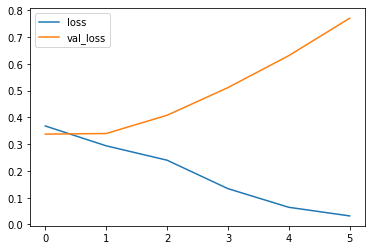

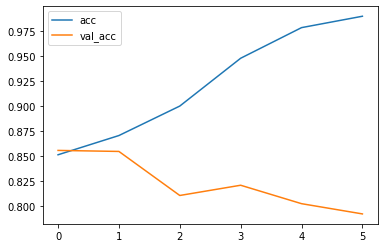

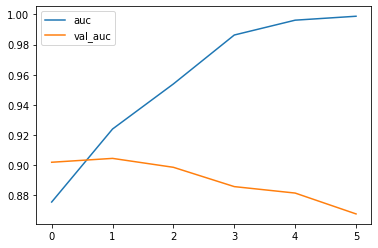

1083/1083 [==============================] - 1s 560us/sample - loss: 0.2948 - tp: 293.0000 - fp: 0.0000e+00 - tn: 657.0000 - fn: 133.0000 - accuracy: 0.8772 - precision: 1.0000 - recall: 0.6878 - auc: 0.9242
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 31s 4ms/sample - loss: 0.3726 - tp: 2190.0000 - fp: 90.0000 - tn: 5250.0000 - fn: 1243.0000 - accuracy: 0.8481 - precision: 0.9605 - recall: 0.6379 - auc: 0.8702 - val_loss: 0.3302 - val_tp: 265.0000 - val_fp: 0.0000e+00 - val_tn: 574.0000 - val_fn: 136.0000 - val_accuracy: 0.8605 - val_precision: 1.0000 - val_recall: 0.6608 - val_auc: 0.9070
Epoch 2/100
8773/8773 [==============================] - 27s 3ms/sample - loss: 0.2959 - tp: 2406.0000 - fp: 125.0000 - tn: 5215.0000 - fn: 1027.0000 - accuracy: 0.8687 - precision: 0.9506 - recall: 0.7008 - auc: 0.9236 - val_loss: 0.3279 - val_tp: 285.0000 - val_fp: 31.0000 - val_tn: 543.0000 - val_fn: 116.0000 - val_accur

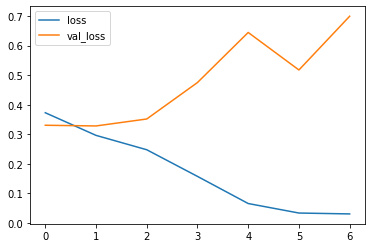

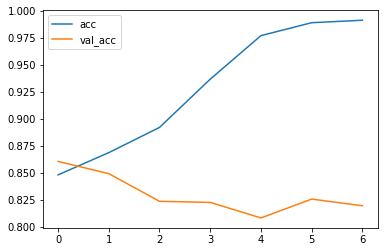

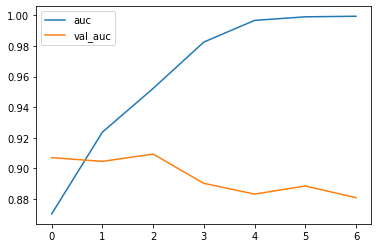

1083/1083 [==============================] - 1s 566us/sample - loss: 0.2913 - tp: 319.0000 - fp: 27.0000 - tn: 630.0000 - fn: 107.0000 - accuracy: 0.8763 - precision: 0.9220 - recall: 0.7488 - auc: 0.9302
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 32s 4ms/sample - loss: 0.3542 - tp: 2133.0000 - fp: 15.0000 - tn: 5328.0000 - fn: 1297.0000 - accuracy: 0.8505 - precision: 0.9930 - recall: 0.6219 - auc: 0.8850 - val_loss: 0.3206 - val_tp: 265.0000 - val_fp: 0.0000e+00 - val_tn: 571.0000 - val_fn: 139.0000 - val_accuracy: 0.8574 - val_precision: 1.0000 - val_recall: 0.6559 - val_auc: 0.9099
Epoch 2/100
8773/8773 [==============================] - 27s 3ms/sample - loss: 0.2854 - tp: 2318.0000 - fp: 24.0000 - tn: 5319.0000 - fn: 1112.0000 - accuracy: 0.8705 - precision: 0.9898 - recall: 0.6758 - auc: 0.9292 - val_loss: 0.3271 - val_tp: 271.0000 - val_fp: 9.0000 - val_tn: 562.0000 - val_fn: 133.0000 - val_accuracy: 

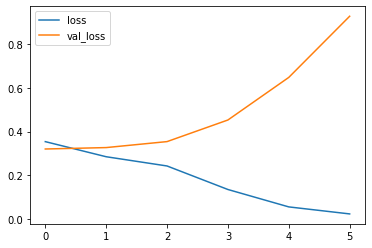

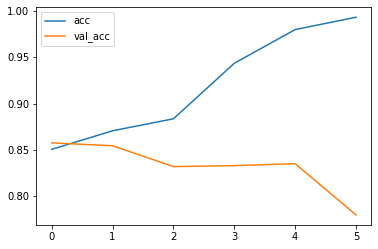

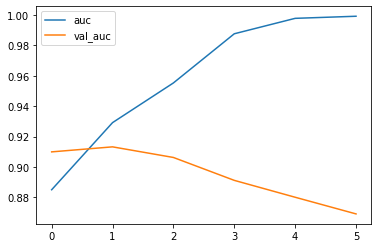

1083/1083 [==============================] - 1s 580us/sample - loss: 0.3314 - tp: 282.0000 - fp: 1.0000 - tn: 656.0000 - fn: 144.0000 - accuracy: 0.8661 - precision: 0.9965 - recall: 0.6620 - auc: 0.8919
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 35s 4ms/sample - loss: 0.3583 - tp: 2145.0000 - fp: 46.0000 - tn: 5292.0000 - fn: 1290.0000 - accuracy: 0.8477 - precision: 0.9790 - recall: 0.6245 - auc: 0.8835 - val_loss: 0.3189 - val_tp: 266.0000 - val_fp: 1.0000 - val_tn: 575.0000 - val_fn: 133.0000 - val_accuracy: 0.8626 - val_precision: 0.9963 - val_recall: 0.6667 - val_auc: 0.9089
Epoch 2/100
8773/8773 [==============================] - 26s 3ms/sample - loss: 0.2923 - tp: 2391.0000 - fp: 107.0000 - tn: 5231.0000 - fn: 1044.0000 - accuracy: 0.8688 - precision: 0.9572 - recall: 0.6961 - auc: 0.9271 - val_loss: 0.3218 - val_tp: 285.0000 - val_fp: 23.0000 - val_tn: 553.0000 - val_fn: 114.0000 - val_accuracy: 0.8

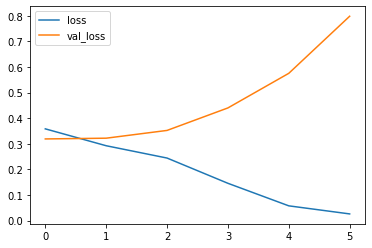

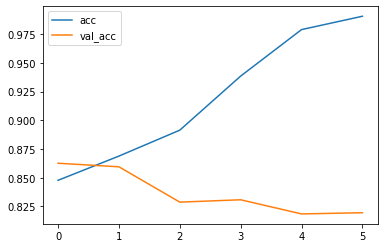

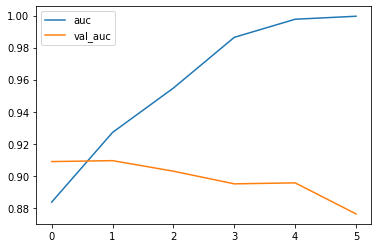

1083/1083 [==============================] - 1s 563us/sample - loss: 0.2794 - tp: 304.0000 - fp: 0.0000e+00 - tn: 657.0000 - fn: 122.0000 - accuracy: 0.8873 - precision: 1.0000 - recall: 0.7136 - auc: 0.9247
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 30s 3ms/sample - loss: 0.3608 - tp: 2174.0000 - fp: 35.0000 - tn: 5300.0000 - fn: 1264.0000 - accuracy: 0.8519 - precision: 0.9842 - recall: 0.6323 - auc: 0.8778 - val_loss: 0.3171 - val_tp: 263.0000 - val_fp: 0.0000e+00 - val_tn: 579.0000 - val_fn: 133.0000 - val_accuracy: 0.8636 - val_precision: 1.0000 - val_recall: 0.6641 - val_auc: 0.9108
Epoch 2/100
8773/8773 [==============================] - 27s 3ms/sample - loss: 0.2977 - tp: 2400.0000 - fp: 109.0000 - tn: 5226.0000 - fn: 1038.0000 - accuracy: 0.8693 - precision: 0.9566 - recall: 0.6981 - auc: 0.9255 - val_loss: 0.3231 - val_tp: 288.0000 - val_fp: 39.0000 - val_tn: 540.0000 - val_fn: 108.0000 - val_accur

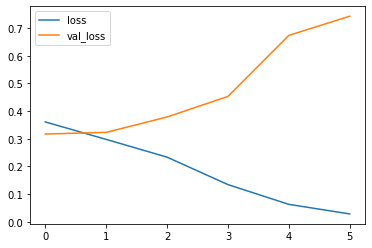

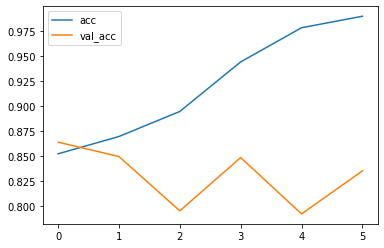

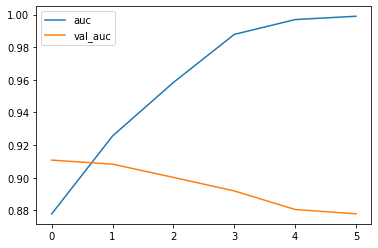

1083/1083 [==============================] - 1s 548us/sample - loss: 0.3352 - tp: 269.0000 - fp: 1.0000 - tn: 656.0000 - fn: 157.0000 - accuracy: 0.8541 - precision: 0.9963 - recall: 0.6315 - auc: 0.8988
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 31s 3ms/sample - loss: 0.3753 - tp: 2121.0000 - fp: 72.0000 - tn: 5265.0000 - fn: 1315.0000 - accuracy: 0.8419 - precision: 0.9672 - recall: 0.6173 - auc: 0.8661 - val_loss: 0.3196 - val_tp: 264.0000 - val_fp: 0.0000e+00 - val_tn: 577.0000 - val_fn: 134.0000 - val_accuracy: 0.8626 - val_precision: 1.0000 - val_recall: 0.6633 - val_auc: 0.9108
Epoch 2/100
8773/8773 [==============================] - 28s 3ms/sample - loss: 0.3019 - tp: 2392.0000 - fp: 82.0000 - tn: 5255.0000 - fn: 1044.0000 - accuracy: 0.8717 - precision: 0.9669 - recall: 0.6962 - auc: 0.9222 - val_loss: 0.3138 - val_tp: 276.0000 - val_fp: 10.0000 - val_tn: 567.0000 - val_fn: 122.0000 - val_accuracy: 

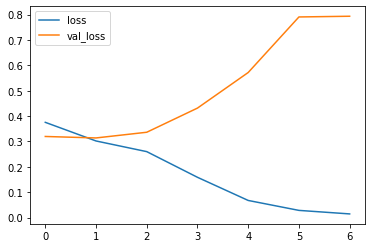

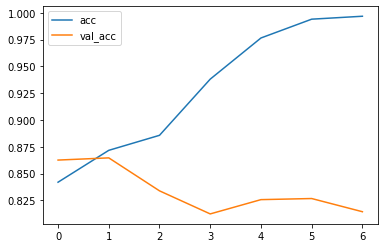

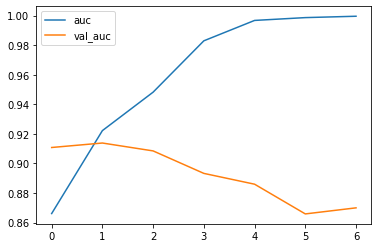

1083/1083 [==============================] - 1s 549us/sample - loss: 0.2831 - tp: 298.0000 - fp: 7.0000 - tn: 650.0000 - fn: 128.0000 - accuracy: 0.8753 - precision: 0.9770 - recall: 0.6995 - auc: 0.9357
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 36s 4ms/sample - loss: 0.3606 - tp: 2148.0000 - fp: 21.0000 - tn: 5322.0000 - fn: 1282.0000 - accuracy: 0.8515 - precision: 0.9903 - recall: 0.6262 - auc: 0.8831 - val_loss: 0.3176 - val_tp: 269.0000 - val_fp: 0.0000e+00 - val_tn: 571.0000 - val_fn: 135.0000 - val_accuracy: 0.8615 - val_precision: 1.0000 - val_recall: 0.6658 - val_auc: 0.9103
Epoch 2/100
8773/8773 [==============================] - 26s 3ms/sample - loss: 0.2846 - tp: 2405.0000 - fp: 112.0000 - tn: 5231.0000 - fn: 1025.0000 - accuracy: 0.8704 - precision: 0.9555 - recall: 0.7012 - auc: 0.9306 - val_loss: 0.3208 - val_tp: 289.0000 - val_fp: 37.0000 - val_tn: 534.0000 - val_fn: 115.0000 - val_accuracy:

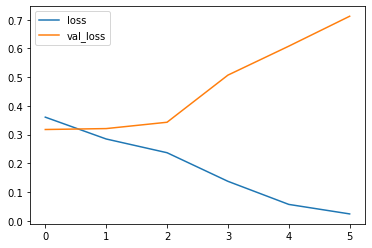

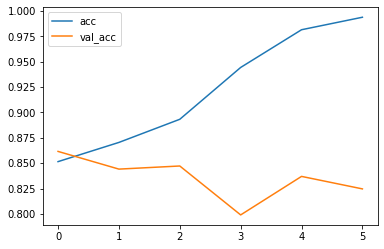

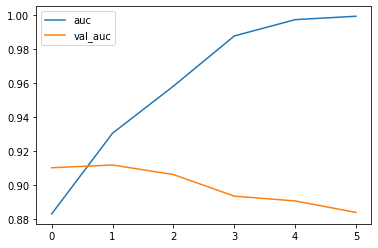

1083/1083 [==============================] - 1s 565us/sample - loss: 0.2896 - tp: 290.0000 - fp: 0.0000e+00 - tn: 657.0000 - fn: 136.0000 - accuracy: 0.8744 - precision: 1.0000 - recall: 0.6808 - auc: 0.9266
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 30s 3ms/sample - loss: 0.3585 - tp: 2178.0000 - fp: 23.0000 - tn: 5313.0000 - fn: 1259.0000 - accuracy: 0.8539 - precision: 0.9896 - recall: 0.6337 - auc: 0.8808 - val_loss: 0.3077 - val_tp: 269.0000 - val_fp: 1.0000 - val_tn: 577.0000 - val_fn: 128.0000 - val_accuracy: 0.8677 - val_precision: 0.9963 - val_recall: 0.6776 - val_auc: 0.9143
Epoch 2/100
8773/8773 [==============================] - 26s 3ms/sample - loss: 0.2878 - tp: 2379.0000 - fp: 80.0000 - tn: 5256.0000 - fn: 1058.0000 - accuracy: 0.8703 - precision: 0.9675 - recall: 0.6922 - auc: 0.9288 - val_loss: 0.3210 - val_tp: 268.0000 - val_fp: 3.0000 - val_tn: 575.0000 - val_fn: 129.0000 - val_accuracy: 0

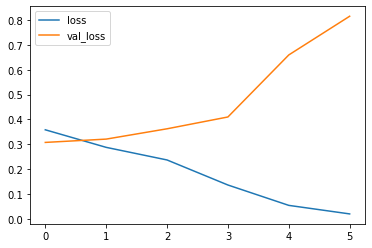

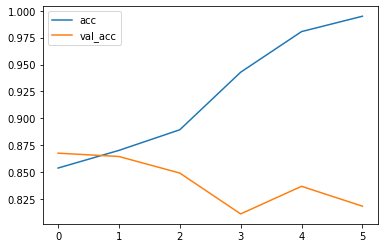

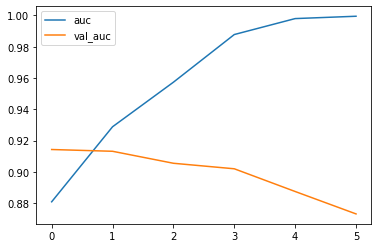

1083/1083 [==============================] - 1s 554us/sample - loss: 0.3163 - tp: 281.0000 - fp: 2.0000 - tn: 655.0000 - fn: 145.0000 - accuracy: 0.8643 - precision: 0.9929 - recall: 0.6596 - auc: 0.9094
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/100
8773/8773 [==============================] - 29s 3ms/sample - loss: 0.3576 - tp: 2172.0000 - fp: 27.0000 - tn: 5321.0000 - fn: 1253.0000 - accuracy: 0.8541 - precision: 0.9877 - recall: 0.6342 - auc: 0.8786 - val_loss: 0.3278 - val_tp: 273.0000 - val_fp: 0.0000e+00 - val_tn: 566.0000 - val_fn: 136.0000 - val_accuracy: 0.8605 - val_precision: 1.0000 - val_recall: 0.6675 - val_auc: 0.9084
Epoch 2/100
8773/8773 [==============================] - 27s 3ms/sample - loss: 0.2886 - tp: 2357.0000 - fp: 42.0000 - tn: 5306.0000 - fn: 1068.0000 - accuracy: 0.8735 - precision: 0.9825 - recall: 0.6882 - auc: 0.9275 - val_loss: 0.3263 - val_tp: 282.0000 - val_fp: 15.0000 - val_tn: 551.0000 - val_fn: 127.0000 - val_accuracy: 

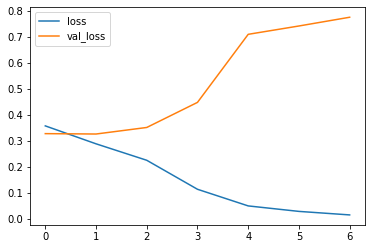

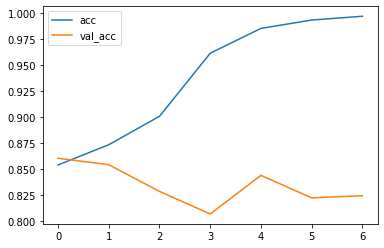

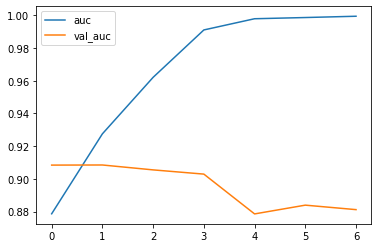

1083/1083 [==============================] - 1s 565us/sample - loss: 0.3170 - tp: 287.0000 - fp: 13.0000 - tn: 644.0000 - fn: 139.0000 - accuracy: 0.8596 - precision: 0.9567 - recall: 0.6737 - auc: 0.9135


In [130]:
# some configuration
VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 100   # number of complete passes through the training dataset
LEARNING_RATE = 0.001
N_SPLITS = 10


print('Building Bi-LSTM model...')
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state = 7)
cvscores_bilstm = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen-kappa-score'])
labels = data_cleaned['relevance'].values
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]


for train, test in kfold.split(texts, labels):

  model = tf.keras.Sequential([
       tf.keras.layers.Embedding(num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=True),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
       #tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, padding='valid', activation='relu', strides=1),
       #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
       tf.keras.layers.GlobalAveragePooling1D(),
       tf.keras.layers.Dense(32, activation='relu'),
       tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  
  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = METRICS,
  
  )



# Training model:

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
#  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
# fit model
# load a saved model

#  from sklearn.utils import class_weight

  print('Training model...')
  r = model.fit(
    texts[train],
    labels[train],
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    #callbacks=[history, lrate]
    #callbacks=[lr_schedule]
    callbacks=[es]
    #class_weight = class_weight_dict
    #use_multiprocessing=True
  )

#  saved_model = tf.keras.models.load_model('best_model.h5')
#  saved_model.summary()

  model.summary()

# plot some data
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

# accuracies
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.legend()
  plt.show()

# auc
  plt.plot(r.history['auc'], label='auc')
  plt.plot(r.history['val_auc'], label='val_auc')
  plt.legend()
  plt.show()



  #scores = saved_model.evaluate(x = texts[test], y = labels[test])
  scores = model.evaluate(x = texts[test], y = labels[test])
  y_pred = model.predict(x=texts[test])
  y_pred = K.round(y_pred)
  ck = cohen_kappa_score(labels[test], y_pred)
  cvscores_bilstm = cvscores_bilstm.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 
                              'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 
                              'f1': 2 * (scores[6] * scores[7]) / (scores[6] + scores[7]),'auc': scores[8],
                              'cohen-kappa-score': ck}, ignore_index=True)

In [131]:
cvscores_bilstm

tp    fp     tn     fn  ...    recall        f1       auc  cohen-kappa-score
0  274.0   0.0  658.0  152.0  ...  0.643192  0.782857  0.907127           0.686366
1  293.0   0.0  657.0  133.0  ...  0.687793  0.815021  0.924161           0.727736
2  319.0  27.0  630.0  107.0  ...  0.748826  0.826425  0.930231           0.731893
3  282.0   1.0  656.0  144.0  ...  0.661972  0.795487  0.891938           0.701869
4  304.0   0.0  657.0  122.0  ...  0.713615  0.832877  0.924672           0.751448
5  269.0   1.0  656.0  157.0  ...  0.631455  0.772989  0.898831           0.673277
6  298.0   7.0  650.0  128.0  ...  0.699531  0.815321  0.935691           0.725082
7  290.0   0.0  657.0  136.0  ...  0.680751  0.810056  0.926614           0.721229
8  281.0   2.0  655.0  145.0  ...  0.659624  0.792666  0.909410           0.697757
9  287.0  13.0  644.0  139.0  ...  0.673709  0.790634  0.913480           0.689789

[10 rows x 10 columns]

In [132]:
cvscores_bilstm.mean(axis = 0)

tp                   289.700000
fp                     5.100000
tn                   652.000000
fn                   136.300000
accuracy               0.869450
precision              0.984138
recall                 0.680047
f1                     0.803433
auc                    0.916215
cohen-kappa-score      0.710644
dtype: float64

In [0]:
cvscores_bilstm.to_csv("/gdrive/My Drive/bilstm.csv")

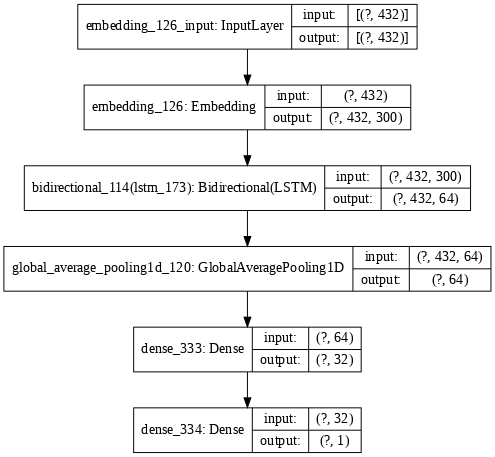

In [134]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot_bilstm.png', show_shapes=True, show_layer_names=True, dpi = 70)

##### Bi-LSTM + tf-idf (concatenate)

Building Bi-LSTM model...
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_51 (Embedding)        (None, 432, 300)     12867900    input_21[0][0]                   
__________________________________________________________________________________________________
layer_normalization_10 (LayerNo (None, 500)          1000        input_22[0][0]                   
_________________________________________________________________

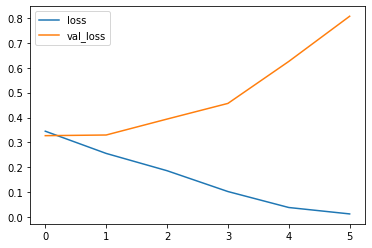

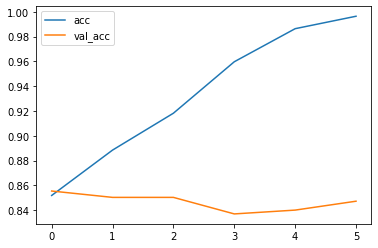

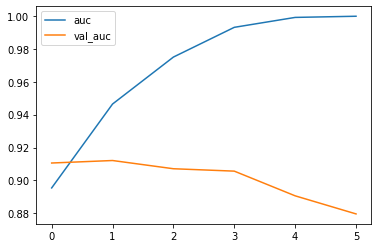

1084/1084 [==============================] - 1s 543us/sample - loss: 0.3370 - tp: 269.0000 - fp: 5.0000 - tn: 653.0000 - fn: 157.0000 - accuracy: 0.8506 - precision: 0.9818 - recall: 0.6315 - auc: 0.9077
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_51 (Embedding)        (None, 432, 300)     12867900    input_23[0][0]                   
_____________________________________________________________________________________

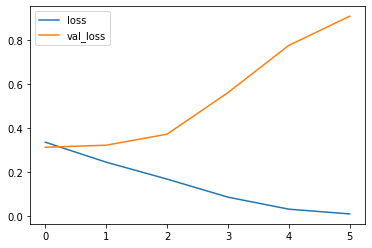

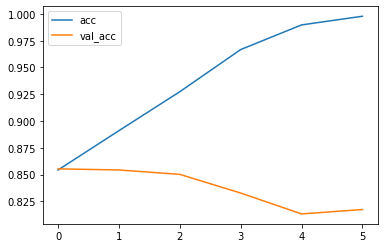

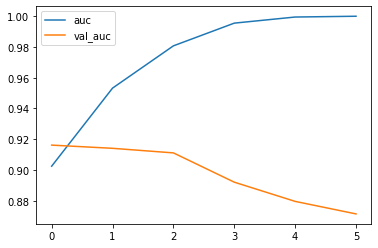

1083/1083 [==============================] - 1s 553us/sample - loss: 0.3073 - tp: 284.0000 - fp: 7.0000 - tn: 650.0000 - fn: 142.0000 - accuracy: 0.8624 - precision: 0.9759 - recall: 0.6667 - auc: 0.9210
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_51 (Embedding)        (None, 432, 300)     12867900    input_25[0][0]                   
_____________________________________________________________________________________

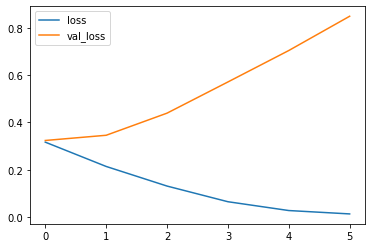

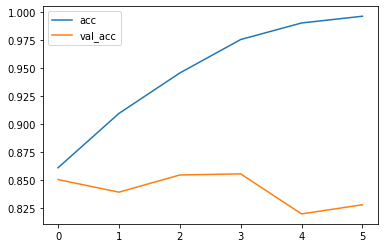

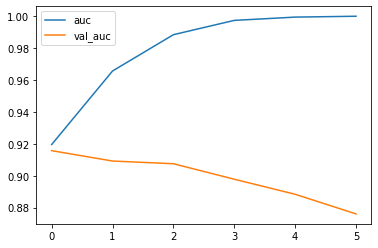

1083/1083 [==============================] - 1s 563us/sample - loss: 0.2777 - tp: 335.0000 - fp: 38.0000 - tn: 619.0000 - fn: 91.0000 - accuracy: 0.8809 - precision: 0.8981 - recall: 0.7864 - auc: 0.9381
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_51 (Embedding)        (None, 432, 300)     12867900    input_27[0][0]                   
_____________________________________________________________________________________

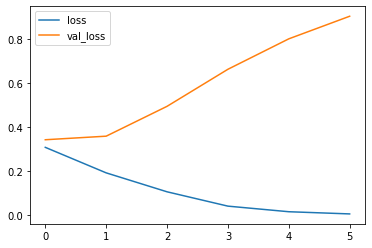

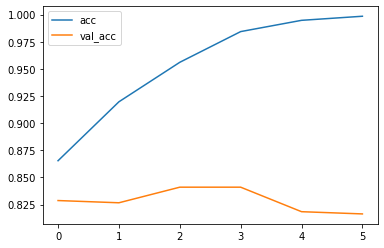

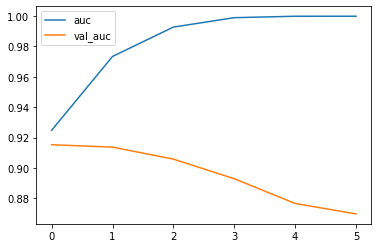

1083/1083 [==============================] - 1s 592us/sample - loss: 0.2483 - tp: 369.0000 - fp: 72.0000 - tn: 585.0000 - fn: 57.0000 - accuracy: 0.8809 - precision: 0.8367 - recall: 0.8662 - auc: 0.9563
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_51 (Embedding)        (None, 432, 300)     12867900    input_29[0][0]                   
_____________________________________________________________________________________

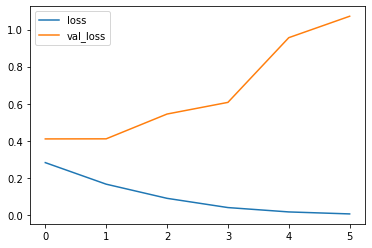

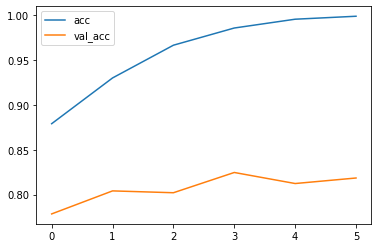

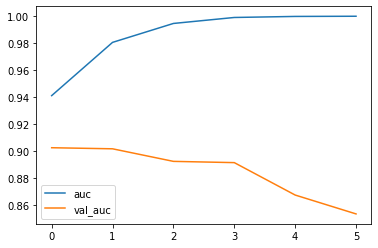

1083/1083 [==============================] - 1s 557us/sample - loss: 0.2587 - tp: 400.0000 - fp: 108.0000 - tn: 549.0000 - fn: 26.0000 - accuracy: 0.8763 - precision: 0.7874 - recall: 0.9390 - auc: 0.9657
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_51 (Embedding)        (None, 432, 300)     12867900    input_31[0][0]                   
____________________________________________________________________________________

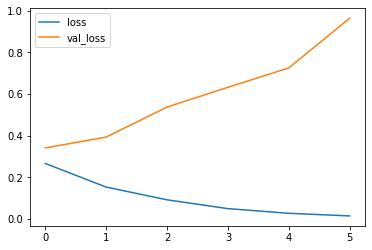

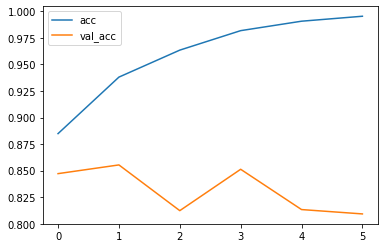

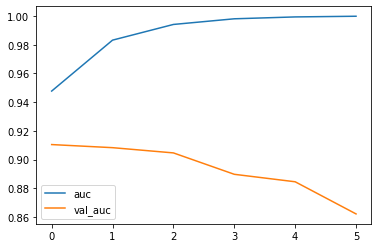

1083/1083 [==============================] - 1s 558us/sample - loss: 0.2194 - tp: 357.0000 - fp: 21.0000 - tn: 636.0000 - fn: 69.0000 - accuracy: 0.9169 - precision: 0.9444 - recall: 0.8380 - auc: 0.9627
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_51 (Embedding)        (None, 432, 300)     12867900    input_33[0][0]                   
_____________________________________________________________________________________

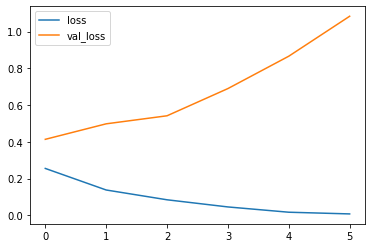

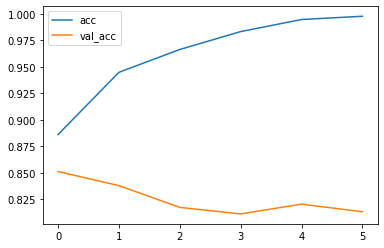

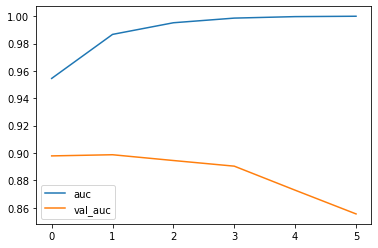

1083/1083 [==============================] - 1s 566us/sample - loss: 0.1998 - tp: 343.0000 - fp: 11.0000 - tn: 646.0000 - fn: 83.0000 - accuracy: 0.9132 - precision: 0.9689 - recall: 0.8052 - auc: 0.9745
Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_51 (Embedding)        (None, 432, 300)     12867900    input_35[0][0]                   
_____________________________________________________________________________________

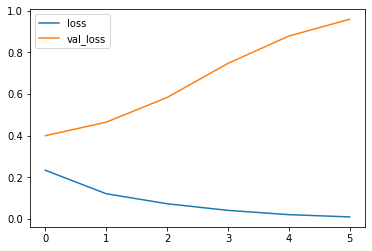

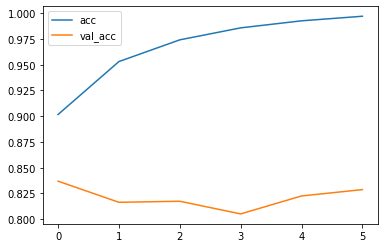

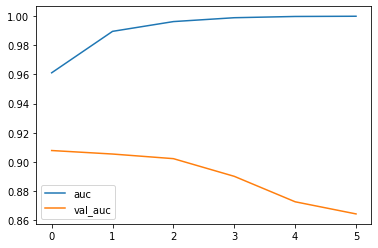

1083/1083 [==============================] - 3s 3ms/sample - loss: 0.2055 - tp: 367.0000 - fp: 38.0000 - tn: 619.0000 - fn: 59.0000 - accuracy: 0.9104 - precision: 0.9062 - recall: 0.8615 - auc: 0.9695
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_51 (Embedding)        (None, 432, 300)     12867900    input_37[0][0]                   
_______________________________________________________________________________________

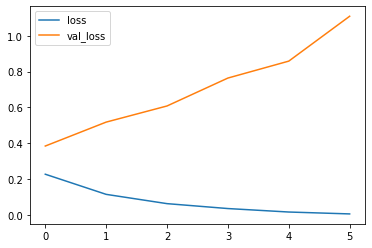

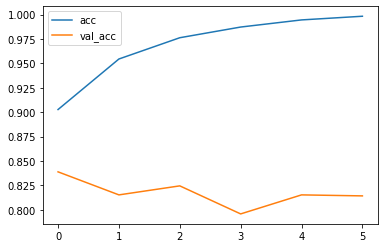

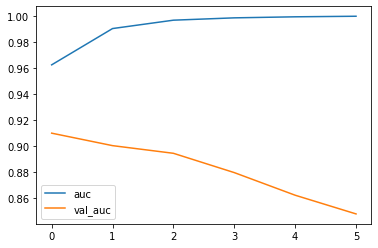

1083/1083 [==============================] - 1s 554us/sample - loss: 0.1602 - tp: 385.0000 - fp: 34.0000 - tn: 623.0000 - fn: 41.0000 - accuracy: 0.9307 - precision: 0.9189 - recall: 0.9038 - auc: 0.9802
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 432)]        0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_51 (Embedding)        (None, 432, 300)     12867900    input_39[0][0]                   
_____________________________________________________________________________________

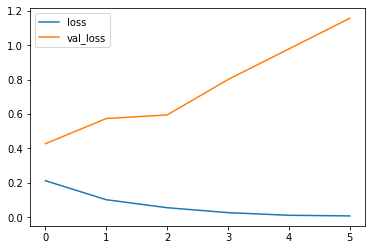

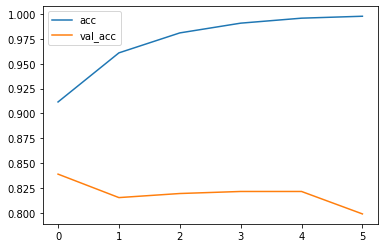

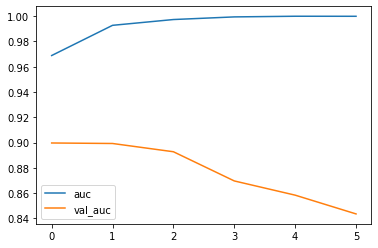

1083/1083 [==============================] - 1s 542us/sample - loss: 0.1485 - tp: 372.0000 - fp: 10.0000 - tn: 647.0000 - fn: 54.0000 - accuracy: 0.9409 - precision: 0.9738 - recall: 0.8732 - auc: 0.9862


In [71]:
# some configuration
VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 100   # number of complete passes through the training dataset
LEARNING_RATE = 0.001
N_SPLITS = 10


print('Building Bi-LSTM model...')
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state = 9)
cvscores_bilstm_tf = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen-kappa-score'])
labels = data_cleaned['relevance'].values
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]



embedding_layer = tf.keras.layers.Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=True
)


for train, test in kfold.split(texts_tf, labels):

  x_train = texts_tf[train]
  x_test = texts_tf[test]
  x_train_1 = x_train[:, : MAX_SEQUENCE_LENGTH] # training set for word embeddings using GloVe
  x_train_2 = x_train[:, MAX_SEQUENCE_LENGTH:] # training set for tfidf feature
  x_test_1 = x_test[:, :MAX_SEQUENCE_LENGTH] # testing set for word embedding using GloVe
  x_test_2 = x_test[:, MAX_SEQUENCE_LENGTH:] # testing set for tfidf feature
  y_train = labels[train]
  y_test = labels[test]

  input_1 = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,)) # input layer using word embeddings
  x = embedding_layer(input_1)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)   # LSTM layer on embedding layer
 
  input_2 = tf.keras.Input(shape=(500,))  #input layer using tfidf
  tf_vec = tf.keras.layers.LayerNormalization()(input_2)  # tfidf layer
  tf_vec = tf.keras.layers.Dense(32, activation = 'relu')(tf_vec) # reduce the dimension of tfidf layer to 32
  
  concat_layer = tf.keras.layers.Concatenate()([x, tf_vec])  # concatenate LSTM and tfidf layer

  output_vector = tf.keras.layers.Dense(16, activation='relu')(concat_layer)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(output_vector)
  model = tf.keras.models.Model([input_1, input_2], output)
  model.summary()
  
  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = METRICS,
  
  )



# Training model:

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)  # early stopping to avoid overfitting
#  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
# fit model
# load a saved model

#  from sklearn.utils import class_weight

  print('Training model...')
  r = model.fit(
    [x_train_1, x_train_2],
    y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    #callbacks=[history, lrate]
    #callbacks=[lr_schedule]
    callbacks=[es]
    #class_weight = class_weight_dict
    #use_multiprocessing=True
  )

#  saved_model = tf.keras.models.load_model('best_model.h5')
#  saved_model.summary()

  model.summary()

# plot some data
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

# accuracies
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.legend()
  plt.show()

# auc
  plt.plot(r.history['auc'], label='auc')
  plt.plot(r.history['val_auc'], label='val_auc')
  plt.legend()
  plt.show()



  #scores = saved_model.evaluate(x = texts[test], y = labels[test])
  scores = model.evaluate(x = [x_test_1, x_test_2], y = y_test)
  y_pred = model.predict(x=[x_test_1, x_test_2])
  y_pred = K.round(y_pred)
  ck = cohen_kappa_score(labels[test], y_pred)
  cvscores_bilstm_tf = cvscores_bilstm_tf.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 
                              'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 
                              'f1': 2 * (scores[6] * scores[7]) / (scores[6] + scores[7]),'auc': scores[8],
                              'cohen-kappa-score': ck}, ignore_index=True)

In [72]:
cvscores_bilstm_tf

tp     fp     tn     fn  ...    recall        f1       auc  cohen-kappa-score
0  269.0    5.0  653.0  157.0  ...  0.631455  0.768571  0.907719           0.665733
1  284.0    7.0  650.0  142.0  ...  0.666667  0.792190  0.920979           0.694715
2  335.0   38.0  619.0   91.0  ...  0.786385  0.838548  0.938083           0.744837
3  369.0   72.0  585.0   57.0  ...  0.866197  0.851211  0.956316           0.751953
4  400.0  108.0  549.0   26.0  ...  0.938967  0.856531  0.965741           0.749230
5  357.0   21.0  636.0   69.0  ...  0.838028  0.888060  0.962743           0.822354
6  343.0   11.0  646.0   83.0  ...  0.805164  0.879487  0.974502           0.812565
7  367.0   38.0  619.0   59.0  ...  0.861502  0.883273  0.969478           0.810689
8  385.0   34.0  623.0   41.0  ...  0.903756  0.911243  0.980231           0.854474
9  372.0   10.0  647.0   54.0  ...  0.873239  0.920792  0.986237           0.873886

[10 rows x 10 columns]

In [73]:
cvscores_bilstm_tf.mean()

tp                   348.100000
fp                    34.400000
tn                   622.700000
fn                    77.900000
accuracy               0.896320
precision              0.919218
recall                 0.817136
f1                     0.858991
auc                    0.956203
cohen-kappa-score      0.778044
dtype: float64

In [87]:
cvscores_bilstm_tf.mean()

tp                   348.100000
fp                    34.400000
tn                   622.700000
fn                    77.900000
accuracy               0.896320
precision              0.919218
recall                 0.817136
f1                     0.858991
auc                    0.956203
cohen-kappa-score      0.778044
dtype: float64

In [0]:
cvscores_bilstm_tf.to_csv("/gdrive/My Drive/bilstm_tf.csv")

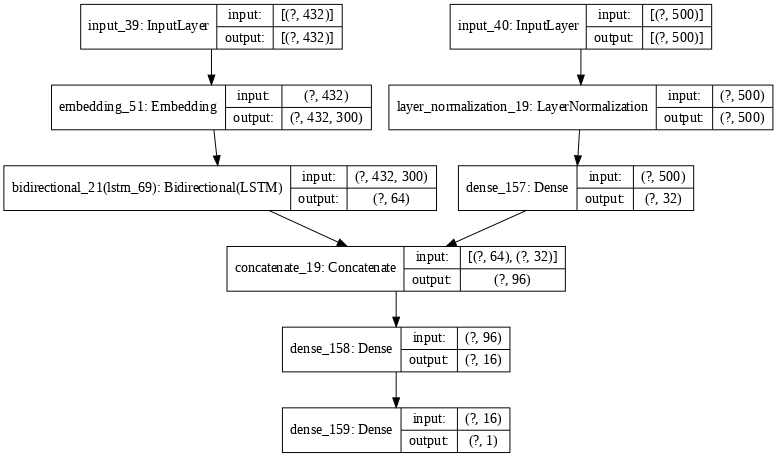

In [75]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot_bilstm_tf.png', show_shapes=True, show_layer_names=True, dpi = 70)

##### 1D CNN + Bi-LSTM

Building Bi-LSTM model...
Training model...
Train on 8772 samples, validate on 975 samples
Epoch 1/1000
8772/8772 [==============================] - 15s 2ms/sample - loss: 0.3450 - tp: 2265.0000 - fp: 79.0000 - tn: 5261.0000 - fn: 1167.0000 - accuracy: 0.8580 - precision: 0.9663 - recall: 0.6600 - auc: 0.8882 - val_loss: 0.3347 - val_tp: 264.0000 - val_fp: 2.0000 - val_tn: 571.0000 - val_fn: 138.0000 - val_accuracy: 0.8564 - val_precision: 0.9925 - val_recall: 0.6567 - val_auc: 0.9036
Epoch 2/1000
8772/8772 [==============================] - 11s 1ms/sample - loss: 0.3171 - tp: 2267.0000 - fp: 29.0000 - tn: 5311.0000 - fn: 1165.0000 - accuracy: 0.8639 - precision: 0.9874 - recall: 0.6605 - auc: 0.9099 - val_loss: 0.3454 - val_tp: 264.0000 - val_fp: 0.0000e+00 - val_tn: 573.0000 - val_fn: 138.0000 - val_accuracy: 0.8585 - val_precision: 1.0000 - val_recall: 0.6567 - val_auc: 0.9078
Epoch 3/1000
8772/8772 [==============================] - 11s 1ms/sample - loss: 0.3031 - tp: 2320.0000 - f

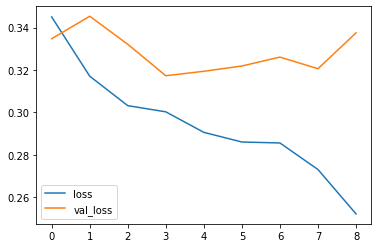

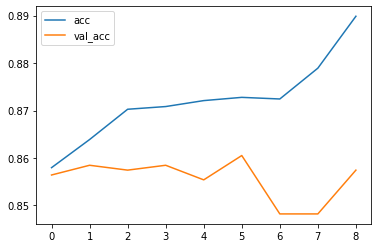

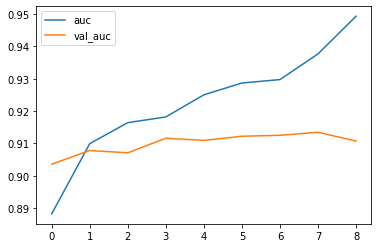

1084/1084 [==============================] - 1s 648us/sample - loss: 0.3213 - tp: 280.0000 - fp: 4.0000 - tn: 654.0000 - fn: 146.0000 - accuracy: 0.8616 - precision: 0.9859 - recall: 0.6573 - auc: 0.9076
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 18s 2ms/sample - loss: 0.3503 - tp: 2228.0000 - fp: 38.0000 - tn: 5306.0000 - fn: 1201.0000 - accuracy: 0.8588 - precision: 0.9832 - recall: 0.6498 - auc: 0.8902 - val_loss: 0.3296 - val_tp: 265.0000 - val_fp: 3.0000 - val_tn: 567.0000 - val_fn: 140.0000 - val_accuracy: 0.8533 - val_precision: 0.9888 - val_recall: 0.6543 - val_auc: 0.9040
Epoch 2/1000
8773/8773 [==============================] - 11s 1ms/sample - loss: 0.3137 - tp: 2308.0000 - fp: 39.0000 - tn: 5305.0000 - fn: 1121.0000 - accuracy: 0.8678 - precision: 0.9834 - recall: 0.6731 - auc: 0.9091 - val_loss: 0.3295 - val_tp: 264.0000 - val_fp: 0.0000e+00 - val_tn: 570.0000 - val_fn: 141.0000 - val_accuracy:

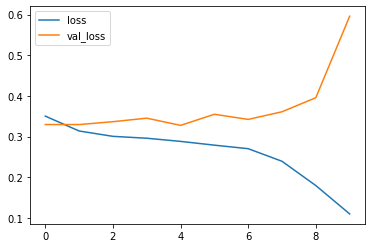

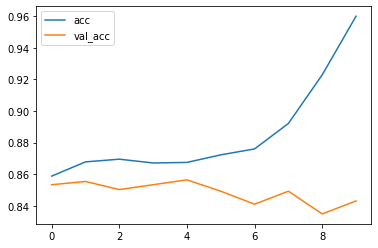

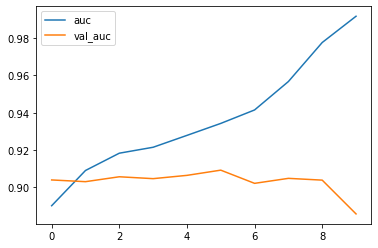

1083/1083 [==============================] - 1s 643us/sample - loss: 0.2900 - tp: 293.0000 - fp: 0.0000e+00 - tn: 657.0000 - fn: 133.0000 - accuracy: 0.8772 - precision: 1.0000 - recall: 0.6878 - auc: 0.9239
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 16s 2ms/sample - loss: 0.3434 - tp: 2252.0000 - fp: 31.0000 - tn: 5309.0000 - fn: 1181.0000 - accuracy: 0.8618 - precision: 0.9864 - recall: 0.6560 - auc: 0.8873 - val_loss: 0.3229 - val_tp: 265.0000 - val_fp: 0.0000e+00 - val_tn: 574.0000 - val_fn: 136.0000 - val_accuracy: 0.8605 - val_precision: 1.0000 - val_recall: 0.6608 - val_auc: 0.9046
Epoch 2/1000
8773/8773 [==============================] - 11s 1ms/sample - loss: 0.3114 - tp: 2299.0000 - fp: 19.0000 - tn: 5321.0000 - fn: 1134.0000 - accuracy: 0.8686 - precision: 0.9918 - recall: 0.6697 - auc: 0.9117 - val_loss: 0.3229 - val_tp: 267.0000 - val_fp: 0.0000e+00 - val_tn: 574.0000 - val_fn: 134.0000 - val_a

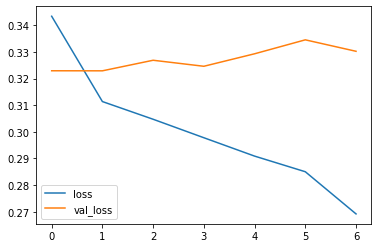

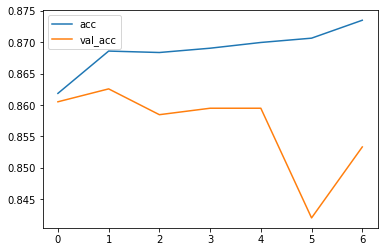

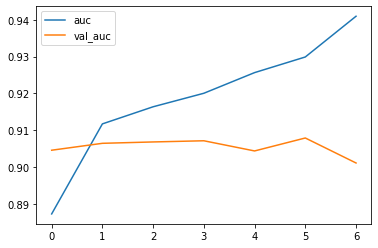

1083/1083 [==============================] - 1s 643us/sample - loss: 0.2948 - tp: 286.0000 - fp: 1.0000 - tn: 656.0000 - fn: 140.0000 - accuracy: 0.8698 - precision: 0.9965 - recall: 0.6714 - auc: 0.9249
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 15s 2ms/sample - loss: 0.3385 - tp: 2253.0000 - fp: 19.0000 - tn: 5324.0000 - fn: 1177.0000 - accuracy: 0.8637 - precision: 0.9916 - recall: 0.6569 - auc: 0.8941 - val_loss: 0.3330 - val_tp: 277.0000 - val_fp: 15.0000 - val_tn: 556.0000 - val_fn: 127.0000 - val_accuracy: 0.8544 - val_precision: 0.9486 - val_recall: 0.6856 - val_auc: 0.9058
Epoch 2/1000
8773/8773 [==============================] - 11s 1ms/sample - loss: 0.3017 - tp: 2321.0000 - fp: 45.0000 - tn: 5298.0000 - fn: 1109.0000 - accuracy: 0.8685 - precision: 0.9810 - recall: 0.6767 - auc: 0.9160 - val_loss: 0.3236 - val_tp: 281.0000 - val_fp: 27.0000 - val_tn: 544.0000 - val_fn: 123.0000 - val_accuracy: 0

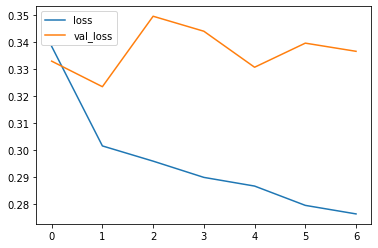

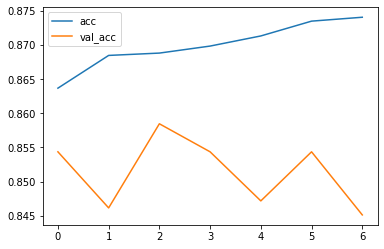

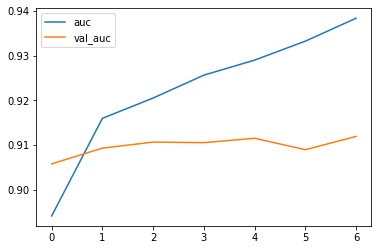

1083/1083 [==============================] - 1s 638us/sample - loss: 0.3414 - tp: 297.0000 - fp: 23.0000 - tn: 634.0000 - fn: 129.0000 - accuracy: 0.8596 - precision: 0.9281 - recall: 0.6972 - auc: 0.8910
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 15s 2ms/sample - loss: 0.3507 - tp: 2212.0000 - fp: 40.0000 - tn: 5298.0000 - fn: 1223.0000 - accuracy: 0.8560 - precision: 0.9822 - recall: 0.6440 - auc: 0.8869 - val_loss: 0.3326 - val_tp: 265.0000 - val_fp: 1.0000 - val_tn: 575.0000 - val_fn: 134.0000 - val_accuracy: 0.8615 - val_precision: 0.9962 - val_recall: 0.6642 - val_auc: 0.9064
Epoch 2/1000
8773/8773 [==============================] - 11s 1ms/sample - loss: 0.3119 - tp: 2302.0000 - fp: 51.0000 - tn: 5287.0000 - fn: 1133.0000 - accuracy: 0.8650 - precision: 0.9783 - recall: 0.6702 - auc: 0.9101 - val_loss: 0.3219 - val_tp: 268.0000 - val_fp: 6.0000 - val_tn: 570.0000 - val_fn: 131.0000 - val_accuracy: 0.

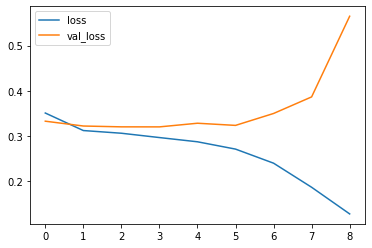

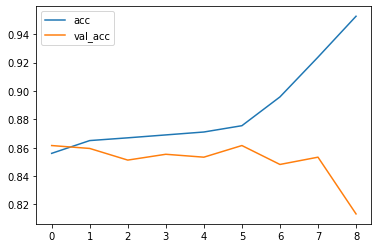

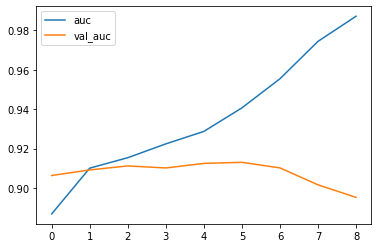

1083/1083 [==============================] - 1s 641us/sample - loss: 0.2817 - tp: 311.0000 - fp: 8.0000 - tn: 649.0000 - fn: 115.0000 - accuracy: 0.8864 - precision: 0.9749 - recall: 0.7300 - auc: 0.9276
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 15s 2ms/sample - loss: 0.3461 - tp: 2260.0000 - fp: 40.0000 - tn: 5295.0000 - fn: 1178.0000 - accuracy: 0.8612 - precision: 0.9826 - recall: 0.6574 - auc: 0.8861 - val_loss: 0.3488 - val_tp: 269.0000 - val_fp: 13.0000 - val_tn: 566.0000 - val_fn: 127.0000 - val_accuracy: 0.8564 - val_precision: 0.9539 - val_recall: 0.6793 - val_auc: 0.9127
Epoch 2/1000
8773/8773 [==============================] - 11s 1ms/sample - loss: 0.3044 - tp: 2322.0000 - fp: 14.0000 - tn: 5321.0000 - fn: 1116.0000 - accuracy: 0.8712 - precision: 0.9940 - recall: 0.6754 - auc: 0.9139 - val_loss: 0.3188 - val_tp: 262.0000 - val_fp: 0.0000e+00 - val_tn: 579.0000 - val_fn: 134.0000 - val_accuracy

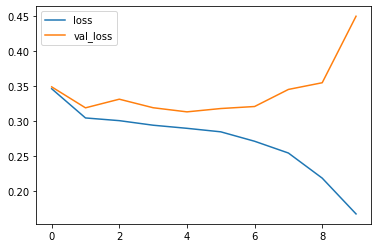

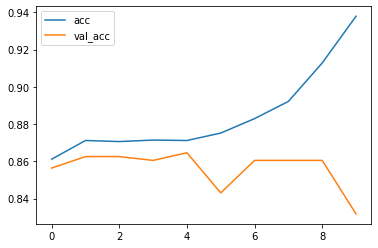

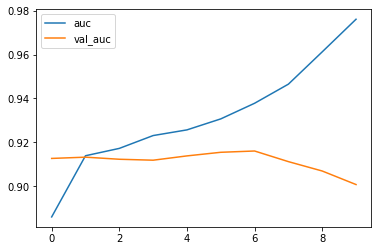

1083/1083 [==============================] - 1s 643us/sample - loss: 0.3314 - tp: 284.0000 - fp: 20.0000 - tn: 637.0000 - fn: 142.0000 - accuracy: 0.8504 - precision: 0.9342 - recall: 0.6667 - auc: 0.9019
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 15s 2ms/sample - loss: 0.3502 - tp: 2239.0000 - fp: 53.0000 - tn: 5284.0000 - fn: 1197.0000 - accuracy: 0.8575 - precision: 0.9769 - recall: 0.6516 - auc: 0.8843 - val_loss: 0.3239 - val_tp: 264.0000 - val_fp: 1.0000 - val_tn: 576.0000 - val_fn: 134.0000 - val_accuracy: 0.8615 - val_precision: 0.9962 - val_recall: 0.6633 - val_auc: 0.9072
Epoch 2/1000
8773/8773 [==============================] - 11s 1ms/sample - loss: 0.3099 - tp: 2302.0000 - fp: 27.0000 - tn: 5310.0000 - fn: 1134.0000 - accuracy: 0.8677 - precision: 0.9884 - recall: 0.6700 - auc: 0.9104 - val_loss: 0.3310 - val_tp: 264.0000 - val_fp: 1.0000 - val_tn: 576.0000 - val_fn: 134.0000 - val_accuracy: 0.

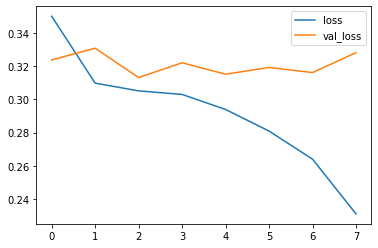

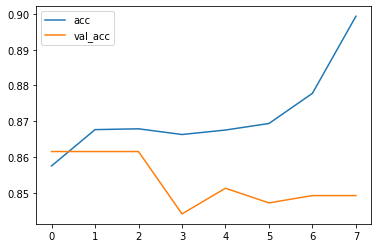

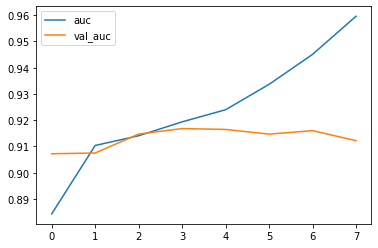

1083/1083 [==============================] - 1s 641us/sample - loss: 0.2712 - tp: 294.0000 - fp: 3.0000 - tn: 654.0000 - fn: 132.0000 - accuracy: 0.8753 - precision: 0.9899 - recall: 0.6901 - auc: 0.9385
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 19s 2ms/sample - loss: 0.3429 - tp: 2250.0000 - fp: 56.0000 - tn: 5287.0000 - fn: 1180.0000 - accuracy: 0.8591 - precision: 0.9757 - recall: 0.6560 - auc: 0.8873 - val_loss: 0.3342 - val_tp: 267.0000 - val_fp: 0.0000e+00 - val_tn: 571.0000 - val_fn: 137.0000 - val_accuracy: 0.8595 - val_precision: 1.0000 - val_recall: 0.6609 - val_auc: 0.9021
Epoch 2/1000
8773/8773 [==============================] - 11s 1ms/sample - loss: 0.3071 - tp: 2294.0000 - fp: 17.0000 - tn: 5326.0000 - fn: 1136.0000 - accuracy: 0.8686 - precision: 0.9926 - recall: 0.6688 - auc: 0.9128 - val_loss: 0.3235 - val_tp: 270.0000 - val_fp: 4.0000 - val_tn: 567.0000 - val_fn: 134.0000 - val_accuracy:

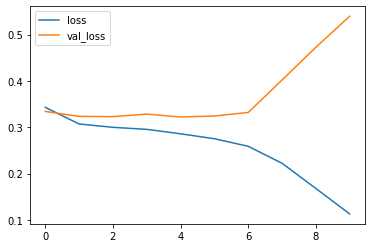

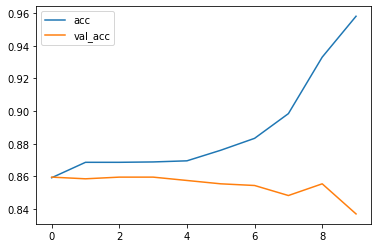

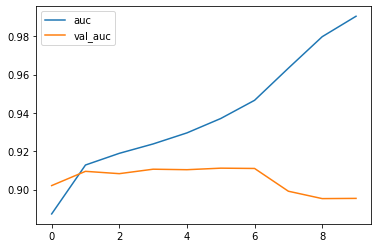

1083/1083 [==============================] - 1s 636us/sample - loss: 0.2911 - tp: 298.0000 - fp: 6.0000 - tn: 651.0000 - fn: 128.0000 - accuracy: 0.8763 - precision: 0.9803 - recall: 0.6995 - auc: 0.9260
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 15s 2ms/sample - loss: 0.3445 - tp: 2266.0000 - fp: 24.0000 - tn: 5312.0000 - fn: 1171.0000 - accuracy: 0.8638 - precision: 0.9895 - recall: 0.6593 - auc: 0.8824 - val_loss: 0.3132 - val_tp: 268.0000 - val_fp: 0.0000e+00 - val_tn: 578.0000 - val_fn: 129.0000 - val_accuracy: 0.8677 - val_precision: 1.0000 - val_recall: 0.6751 - val_auc: 0.9084
Epoch 2/1000
8773/8773 [==============================] - 11s 1ms/sample - loss: 0.3099 - tp: 2298.0000 - fp: 11.0000 - tn: 5325.0000 - fn: 1139.0000 - accuracy: 0.8689 - precision: 0.9952 - recall: 0.6686 - auc: 0.9104 - val_loss: 0.3215 - val_tp: 266.0000 - val_fp: 0.0000e+00 - val_tn: 578.0000 - val_fn: 131.0000 - val_accur

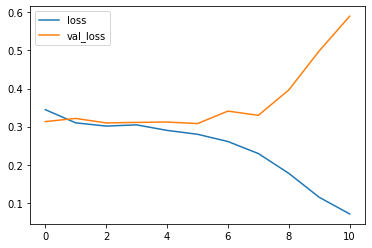

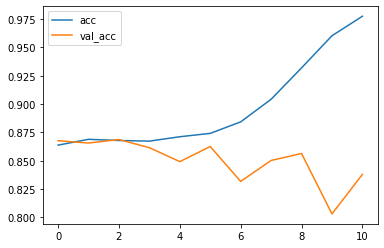

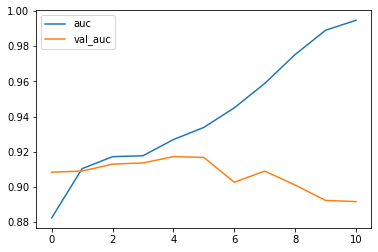

1083/1083 [==============================] - 1s 638us/sample - loss: 0.3075 - tp: 287.0000 - fp: 6.0000 - tn: 651.0000 - fn: 139.0000 - accuracy: 0.8661 - precision: 0.9795 - recall: 0.6737 - auc: 0.9141
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 15s 2ms/sample - loss: 0.3494 - tp: 2250.0000 - fp: 53.0000 - tn: 5295.0000 - fn: 1175.0000 - accuracy: 0.8600 - precision: 0.9770 - recall: 0.6569 - auc: 0.8790 - val_loss: 0.3214 - val_tp: 272.0000 - val_fp: 0.0000e+00 - val_tn: 566.0000 - val_fn: 137.0000 - val_accuracy: 0.8595 - val_precision: 1.0000 - val_recall: 0.6650 - val_auc: 0.9078
Epoch 2/1000
8773/8773 [==============================] - 11s 1ms/sample - loss: 0.3069 - tp: 2291.0000 - fp: 4.0000 - tn: 5344.0000 - fn: 1134.0000 - accuracy: 0.8703 - precision: 0.9983 - recall: 0.6689 - auc: 0.9121 - val_loss: 0.3184 - val_tp: 275.0000 - val_fp: 0.0000e+00 - val_tn: 566.0000 - val_fn: 134.0000 - val_accura

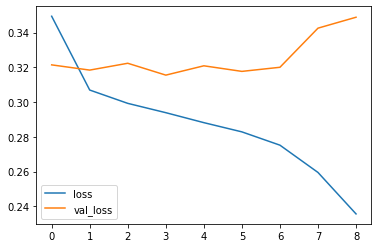

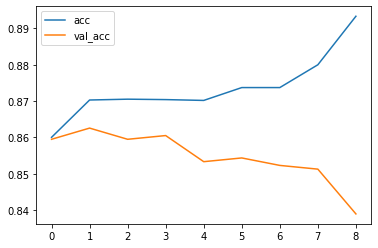

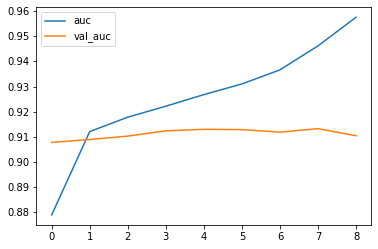

1083/1083 [==============================] - 1s 639us/sample - loss: 0.3067 - tp: 277.0000 - fp: 5.0000 - tn: 652.0000 - fn: 149.0000 - accuracy: 0.8578 - precision: 0.9823 - recall: 0.6502 - auc: 0.9194


In [116]:
# some configuration
VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 1000   # number of complete passes through the training dataset
LEARNING_RATE = 0.001
N_SPLITS = 10

print('Building Bi-LSTM model...')
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state = 7)
cvscores_bilstm_cnn = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen-kappa-score'])
labels = data_cleaned['relevance'].values
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

for train, test in kfold.split(texts, labels):

  model = tf.keras.Sequential([
    #Embedding

       tf.keras.layers.Embedding(num_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False),
       tf.keras.layers.Conv1D(filters = EMBEDDING_DIM, kernel_size = 3, padding='valid', activation='relu'),
       tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
       tf.keras.layers.GlobalAveragePooling1D(),
       tf.keras.layers.Dense(32, activation='relu'),
       tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = METRICS,
  
  )


# Training model:
# early stop model fitting when validation loss does not decrease in 5 steps
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

# fit model
  from sklearn.utils import class_weight

  print('Training model...')
  r = model.fit(
    texts[train],
    labels[train],
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    callbacks=[es]
  )

  model.summary()

# plot some data
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

# accuracies
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.legend()
  plt.show()

# auc
  plt.plot(r.history['auc'], label='auc')
  plt.plot(r.history['val_auc'], label='val_auc')
  plt.legend()
  plt.show()

  scores = model.evaluate(x = texts[test], y = labels[test])
  y_pred = model.predict(x=texts[test])
  y_pred = K.round(y_pred)
  ck = cohen_kappa_score(labels[test], y_pred)
  cvscores_bilstm_cnn = cvscores_bilstm_cnn.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 
                              'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 
                              'f1': 2 * (scores[6] * scores[7]) / (scores[6] + scores[7]),'auc': scores[8],
                              'cohen-kappa-score': ck}, ignore_index=True)

In [117]:
cvscores_bilstm_cnn

tp    fp     tn     fn  ...    recall        f1       auc  cohen-kappa-score
0  280.0   4.0  654.0  146.0  ...  0.657277  0.788732  0.907627           0.691854
1  293.0   0.0  657.0  133.0  ...  0.687793  0.815021  0.923877           0.727736
2  286.0   1.0  656.0  140.0  ...  0.671362  0.802244  0.924890           0.710601
3  297.0  23.0  634.0  129.0  ...  0.697183  0.796247  0.890967           0.692466
4  311.0   8.0  649.0  115.0  ...  0.730047  0.834899  0.927612           0.751033
5  284.0  20.0  637.0  142.0  ...  0.666667  0.778082  0.901859           0.669955
6  294.0   3.0  654.0  132.0  ...  0.690141  0.813278  0.938517           0.724123
7  298.0   6.0  651.0  128.0  ...  0.699531  0.816438  0.926005           0.727000
8  287.0   6.0  651.0  139.0  ...  0.673709  0.798331  0.914142           0.703170
9  277.0   5.0  652.0  149.0  ...  0.650235  0.782486  0.919420           0.683225

[10 rows x 10 columns]

In [118]:
cvscores_bilstm_cnn.mean()

tp                   290.700000
fp                     7.600000
tn                   649.500000
fn                   135.300000
accuracy               0.868064
precision              0.975164
recall                 0.682394
f1                     0.802576
auc                    0.917491
cohen-kappa-score      0.708116
dtype: float64

In [0]:
cvscores_bilstm_cnn.to_csv("/gdrive/My Drive/bilstm_cnn.csv")

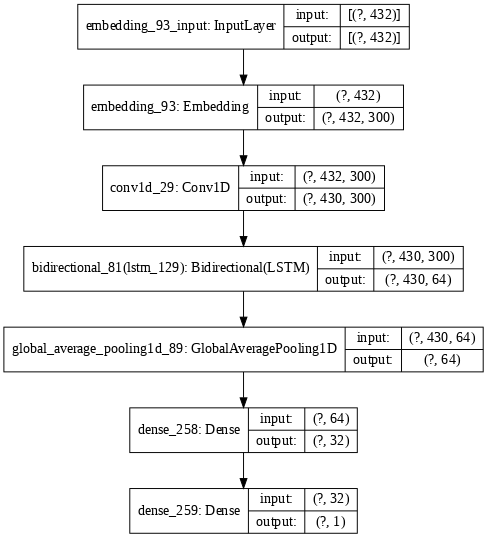

In [111]:
plot_model(model, to_file='model_plot_bilstm_cnn.png', show_shapes=True, show_layer_names=True, dpi = 70)

##### Bi-LSTM + Attention Layer

In [0]:
# assign importance weights to each word
class attention(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

Building Bi-LSTM model...
Training model...
Train on 8772 samples, validate on 975 samples
Epoch 1/1000
8772/8772 [==============================] - 13s 2ms/sample - loss: 0.3616 - tp: 2173.0000 - fp: 39.0000 - tn: 5301.0000 - fn: 1259.0000 - accuracy: 0.8520 - precision: 0.9824 - recall: 0.6332 - auc: 0.8789 - val_loss: 0.3224 - val_tp: 268.0000 - val_fp: 3.0000 - val_tn: 570.0000 - val_fn: 134.0000 - val_accuracy: 0.8595 - val_precision: 0.9889 - val_recall: 0.6667 - val_auc: 0.9060
Epoch 2/1000
8772/8772 [==============================] - 10s 1ms/sample - loss: 0.3013 - tp: 2338.0000 - fp: 38.0000 - tn: 5302.0000 - fn: 1094.0000 - accuracy: 0.8710 - precision: 0.9840 - recall: 0.6812 - auc: 0.9166 - val_loss: 0.3205 - val_tp: 276.0000 - val_fp: 15.0000 - val_tn: 558.0000 - val_fn: 126.0000 - val_accuracy: 0.8554 - val_precision: 0.9485 - val_recall: 0.6866 - val_auc: 0.9103
Epoch 3/1000
8772/8772 [==============================] - 10s 1ms/sample - loss: 0.2934 - tp: 2401.0000 - fp: 

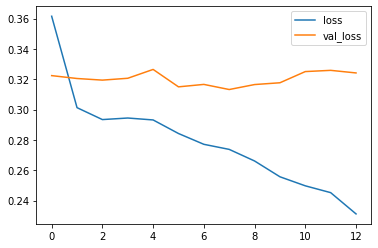

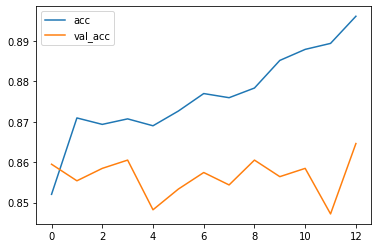

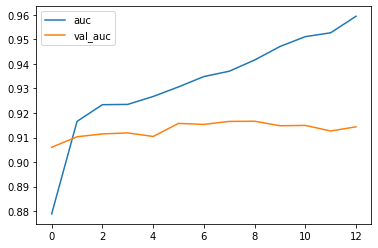

1084/1084 [==============================] - 1s 556us/sample - loss: 0.3255 - tp: 285.0000 - fp: 11.0000 - tn: 647.0000 - fn: 141.0000 - accuracy: 0.8598 - precision: 0.9628 - recall: 0.6690 - auc: 0.9088
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 14s 2ms/sample - loss: 0.3778 - tp: 2156.0000 - fp: 108.0000 - tn: 5236.0000 - fn: 1273.0000 - accuracy: 0.8426 - precision: 0.9523 - recall: 0.6288 - auc: 0.8779 - val_loss: 0.3603 - val_tp: 274.0000 - val_fp: 19.0000 - val_tn: 551.0000 - val_fn: 131.0000 - val_accuracy: 0.8462 - val_precision: 0.9352 - val_recall: 0.6765 - val_auc: 0.8885
Epoch 2/1000
8773/8773 [==============================] - 15s 2ms/sample - loss: 0.3127 - tp: 2286.0000 - fp: 10.0000 - tn: 5334.0000 - fn: 1143.0000 - accuracy: 0.8686 - precision: 0.9956 - recall: 0.6667 - auc: 0.9104 - val_loss: 0.3310 - val_tp: 274.0000 - val_fp: 9.0000 - val_tn: 561.0000 - val_fn: 131.0000 - val_accuracy: 

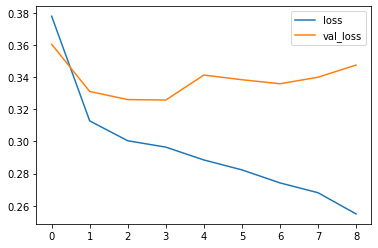

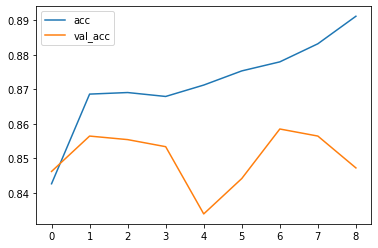

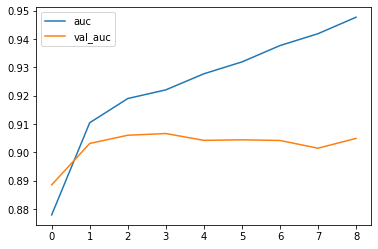

1083/1083 [==============================] - 1s 573us/sample - loss: 0.2873 - tp: 312.0000 - fp: 15.0000 - tn: 642.0000 - fn: 114.0000 - accuracy: 0.8809 - precision: 0.9541 - recall: 0.7324 - auc: 0.9253
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 13s 2ms/sample - loss: 0.3658 - tp: 2131.0000 - fp: 42.0000 - tn: 5298.0000 - fn: 1302.0000 - accuracy: 0.8468 - precision: 0.9807 - recall: 0.6207 - auc: 0.8772 - val_loss: 0.3354 - val_tp: 266.0000 - val_fp: 2.0000 - val_tn: 572.0000 - val_fn: 135.0000 - val_accuracy: 0.8595 - val_precision: 0.9925 - val_recall: 0.6633 - val_auc: 0.8966
Epoch 2/1000
8773/8773 [==============================] - 10s 1ms/sample - loss: 0.3068 - tp: 2314.0000 - fp: 27.0000 - tn: 5313.0000 - fn: 1119.0000 - accuracy: 0.8694 - precision: 0.9885 - recall: 0.6740 - auc: 0.9132 - val_loss: 0.3362 - val_tp: 269.0000 - val_fp: 8.0000 - val_tn: 566.0000 - val_fn: 132.0000 - val_accuracy: 0.

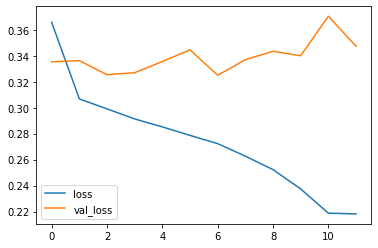

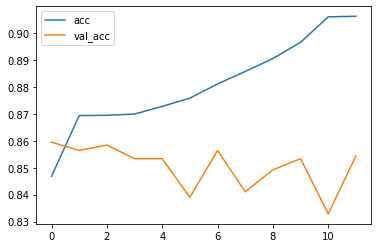

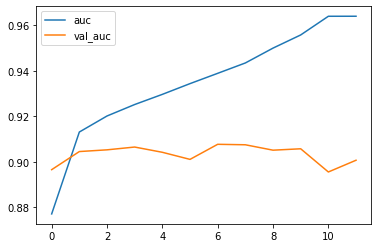

1083/1083 [==============================] - 1s 564us/sample - loss: 0.2905 - tp: 318.0000 - fp: 28.0000 - tn: 629.0000 - fn: 108.0000 - accuracy: 0.8744 - precision: 0.9191 - recall: 0.7465 - auc: 0.9321
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 13s 1ms/sample - loss: 0.3676 - tp: 2144.0000 - fp: 52.0000 - tn: 5291.0000 - fn: 1286.0000 - accuracy: 0.8475 - precision: 0.9763 - recall: 0.6251 - auc: 0.8786 - val_loss: 0.3309 - val_tp: 264.0000 - val_fp: 0.0000e+00 - val_tn: 571.0000 - val_fn: 140.0000 - val_accuracy: 0.8564 - val_precision: 1.0000 - val_recall: 0.6535 - val_auc: 0.9066
Epoch 2/1000
8773/8773 [==============================] - 10s 1ms/sample - loss: 0.3037 - tp: 2345.0000 - fp: 64.0000 - tn: 5279.0000 - fn: 1085.0000 - accuracy: 0.8690 - precision: 0.9734 - recall: 0.6837 - auc: 0.9160 - val_loss: 0.3260 - val_tp: 265.0000 - val_fp: 2.0000 - val_tn: 569.0000 - val_fn: 139.0000 - val_accuracy

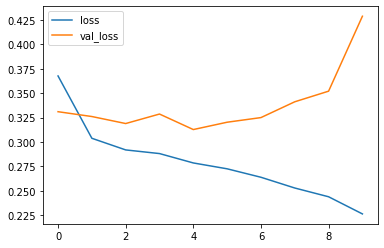

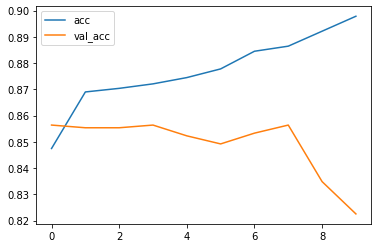

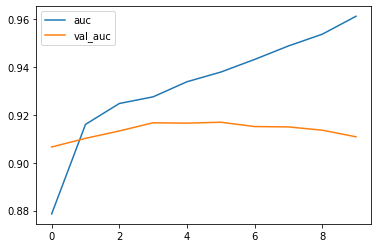

1083/1083 [==============================] - 1s 572us/sample - loss: 0.3314 - tp: 290.0000 - fp: 16.0000 - tn: 641.0000 - fn: 136.0000 - accuracy: 0.8596 - precision: 0.9477 - recall: 0.6808 - auc: 0.8989
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 13s 2ms/sample - loss: 0.3635 - tp: 2113.0000 - fp: 20.0000 - tn: 5318.0000 - fn: 1322.0000 - accuracy: 0.8470 - precision: 0.9906 - recall: 0.6151 - auc: 0.8803 - val_loss: 0.3302 - val_tp: 260.0000 - val_fp: 0.0000e+00 - val_tn: 576.0000 - val_fn: 139.0000 - val_accuracy: 0.8574 - val_precision: 1.0000 - val_recall: 0.6516 - val_auc: 0.9052
Epoch 2/1000
8773/8773 [==============================] - 10s 1ms/sample - loss: 0.3098 - tp: 2311.0000 - fp: 47.0000 - tn: 5291.0000 - fn: 1124.0000 - accuracy: 0.8665 - precision: 0.9801 - recall: 0.6728 - auc: 0.9138 - val_loss: 0.3207 - val_tp: 264.0000 - val_fp: 2.0000 - val_tn: 574.0000 - val_fn: 135.0000 - val_accuracy

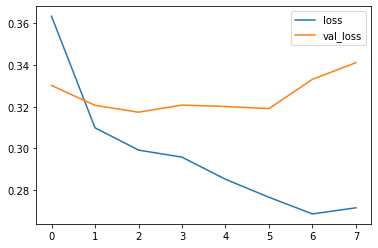

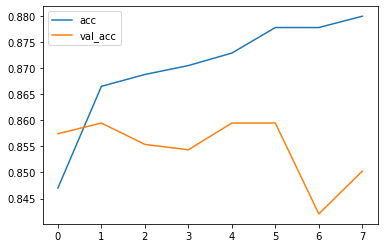

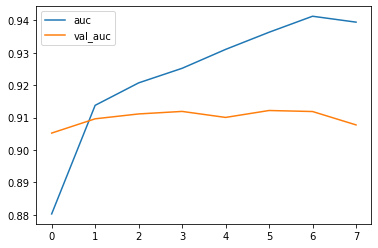

1083/1083 [==============================] - 1s 553us/sample - loss: 0.2775 - tp: 316.0000 - fp: 15.0000 - tn: 642.0000 - fn: 110.0000 - accuracy: 0.8846 - precision: 0.9547 - recall: 0.7418 - auc: 0.9317
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 13s 1ms/sample - loss: 0.3618 - tp: 2177.0000 - fp: 71.0000 - tn: 5264.0000 - fn: 1261.0000 - accuracy: 0.8482 - precision: 0.9684 - recall: 0.6332 - auc: 0.8821 - val_loss: 0.3251 - val_tp: 264.0000 - val_fp: 7.0000 - val_tn: 572.0000 - val_fn: 132.0000 - val_accuracy: 0.8574 - val_precision: 0.9742 - val_recall: 0.6667 - val_auc: 0.9044
Epoch 2/1000
8773/8773 [==============================] - 10s 1ms/sample - loss: 0.3043 - tp: 2366.0000 - fp: 66.0000 - tn: 5269.0000 - fn: 1072.0000 - accuracy: 0.8703 - precision: 0.9729 - recall: 0.6882 - auc: 0.9151 - val_loss: 0.3282 - val_tp: 286.0000 - val_fp: 34.0000 - val_tn: 545.0000 - val_fn: 110.0000 - val_accuracy: 0

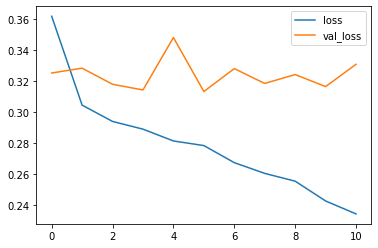

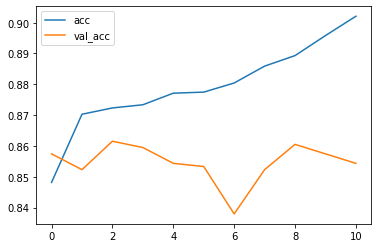

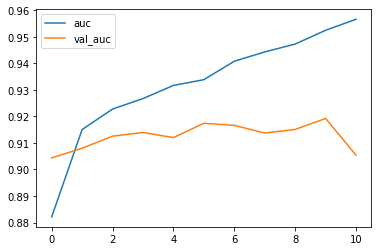

1083/1083 [==============================] - 1s 545us/sample - loss: 0.3367 - tp: 299.0000 - fp: 30.0000 - tn: 627.0000 - fn: 127.0000 - accuracy: 0.8550 - precision: 0.9088 - recall: 0.7019 - auc: 0.9041
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 23s 3ms/sample - loss: 0.3646 - tp: 2110.0000 - fp: 26.0000 - tn: 5311.0000 - fn: 1326.0000 - accuracy: 0.8459 - precision: 0.9878 - recall: 0.6141 - auc: 0.8800 - val_loss: 0.3184 - val_tp: 266.0000 - val_fp: 3.0000 - val_tn: 574.0000 - val_fn: 132.0000 - val_accuracy: 0.8615 - val_precision: 0.9888 - val_recall: 0.6683 - val_auc: 0.9098
Epoch 2/1000
8773/8773 [==============================] - 16s 2ms/sample - loss: 0.3092 - tp: 2324.0000 - fp: 47.0000 - tn: 5290.0000 - fn: 1112.0000 - accuracy: 0.8679 - precision: 0.9802 - recall: 0.6764 - auc: 0.9115 - val_loss: 0.3125 - val_tp: 273.0000 - val_fp: 14.0000 - val_tn: 563.0000 - val_fn: 125.0000 - val_accuracy: 0

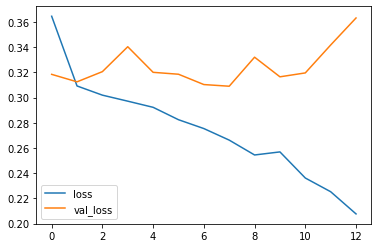

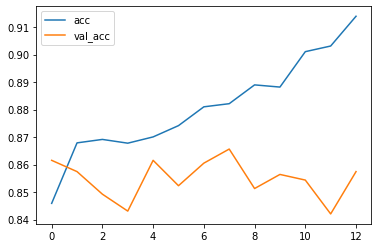

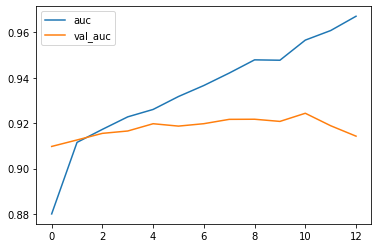

1083/1083 [==============================] - 1s 532us/sample - loss: 0.2680 - tp: 325.0000 - fp: 37.0000 - tn: 620.0000 - fn: 101.0000 - accuracy: 0.8726 - precision: 0.8978 - recall: 0.7629 - auc: 0.9420
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 13s 2ms/sample - loss: 0.3704 - tp: 2111.0000 - fp: 54.0000 - tn: 5289.0000 - fn: 1319.0000 - accuracy: 0.8435 - precision: 0.9751 - recall: 0.6155 - auc: 0.8756 - val_loss: 0.3314 - val_tp: 263.0000 - val_fp: 0.0000e+00 - val_tn: 571.0000 - val_fn: 141.0000 - val_accuracy: 0.8554 - val_precision: 1.0000 - val_recall: 0.6510 - val_auc: 0.9017
Epoch 2/1000
8773/8773 [==============================] - 10s 1ms/sample - loss: 0.3094 - tp: 2290.0000 - fp: 19.0000 - tn: 5324.0000 - fn: 1140.0000 - accuracy: 0.8679 - precision: 0.9918 - recall: 0.6676 - auc: 0.9110 - val_loss: 0.3244 - val_tp: 272.0000 - val_fp: 9.0000 - val_tn: 562.0000 - val_fn: 132.0000 - val_accuracy

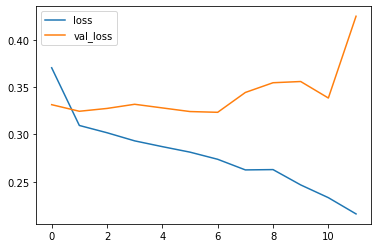

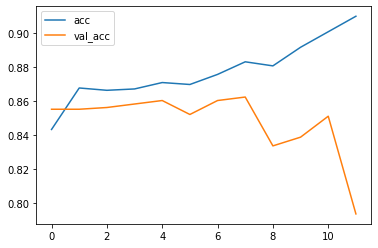

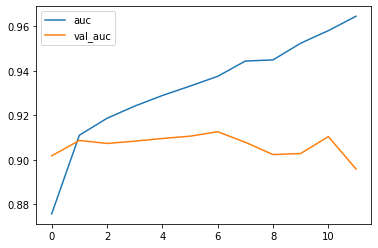

1083/1083 [==============================] - 1s 558us/sample - loss: 0.2898 - tp: 302.0000 - fp: 12.0000 - tn: 645.0000 - fn: 124.0000 - accuracy: 0.8744 - precision: 0.9618 - recall: 0.7089 - auc: 0.9257
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 13s 2ms/sample - loss: 0.3614 - tp: 2124.0000 - fp: 40.0000 - tn: 5296.0000 - fn: 1313.0000 - accuracy: 0.8458 - precision: 0.9815 - recall: 0.6180 - auc: 0.8861 - val_loss: 0.3240 - val_tp: 267.0000 - val_fp: 0.0000e+00 - val_tn: 578.0000 - val_fn: 130.0000 - val_accuracy: 0.8667 - val_precision: 1.0000 - val_recall: 0.6725 - val_auc: 0.9103
Epoch 2/1000
8773/8773 [==============================] - 10s 1ms/sample - loss: 0.3031 - tp: 2348.0000 - fp: 69.0000 - tn: 5267.0000 - fn: 1089.0000 - accuracy: 0.8680 - precision: 0.9715 - recall: 0.6832 - auc: 0.9170 - val_loss: 0.3144 - val_tp: 267.0000 - val_fp: 2.0000 - val_tn: 576.0000 - val_fn: 130.0000 - val_accuracy

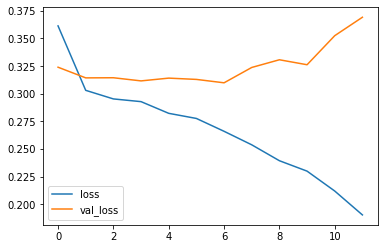

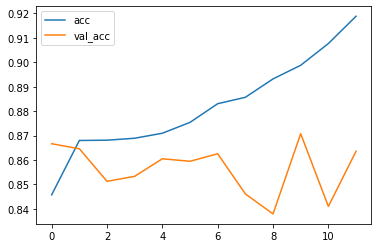

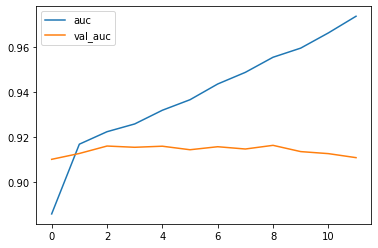

1083/1083 [==============================] - 1s 555us/sample - loss: 0.3126 - tp: 289.0000 - fp: 9.0000 - tn: 648.0000 - fn: 137.0000 - accuracy: 0.8652 - precision: 0.9698 - recall: 0.6784 - auc: 0.9131
Training model...
Train on 8773 samples, validate on 975 samples
Epoch 1/1000
8773/8773 [==============================] - 13s 2ms/sample - loss: 0.3686 - tp: 2177.0000 - fp: 98.0000 - tn: 5250.0000 - fn: 1248.0000 - accuracy: 0.8466 - precision: 0.9569 - recall: 0.6356 - auc: 0.8836 - val_loss: 0.3440 - val_tp: 273.0000 - val_fp: 0.0000e+00 - val_tn: 566.0000 - val_fn: 136.0000 - val_accuracy: 0.8605 - val_precision: 1.0000 - val_recall: 0.6675 - val_auc: 0.9043
Epoch 2/1000
8773/8773 [==============================] - 9s 1ms/sample - loss: 0.3049 - tp: 2335.0000 - fp: 33.0000 - tn: 5315.0000 - fn: 1090.0000 - accuracy: 0.8720 - precision: 0.9861 - recall: 0.6818 - auc: 0.9142 - val_loss: 0.3287 - val_tp: 272.0000 - val_fp: 1.0000 - val_tn: 565.0000 - val_fn: 137.0000 - val_accuracy: 

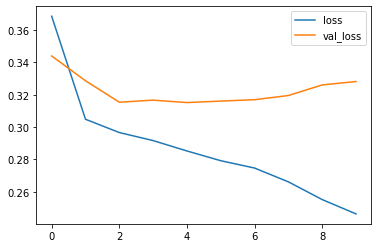

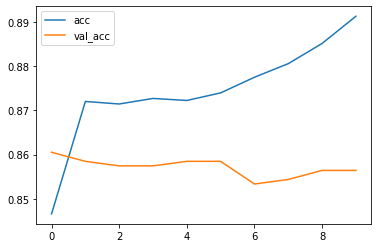

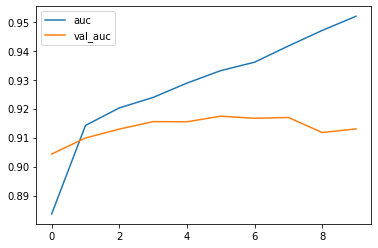

1083/1083 [==============================] - 1s 558us/sample - loss: 0.3078 - tp: 281.0000 - fp: 7.0000 - tn: 650.0000 - fn: 145.0000 - accuracy: 0.8596 - precision: 0.9757 - recall: 0.6596 - auc: 0.9188


In [119]:
# some configuration
VALIDATION_SPLIT = 0.1   
BATCH_SIZE = 32   # number of training samples to work through
EPOCHS = 1000   # number of complete passes through the training dataset
LEARNING_RATE = 0.001
N_SPLITS = 10

print('Building Bi-LSTM model...')
kfold = StratifiedKFold(n_splits=N_SPLITS , shuffle=True, random_state = 7)
cvscores_bilstm_att = pd.DataFrame(columns = ['tp', 'fp', 'tn', 'fn', 'accuracy','precision', 'recall', 'f1', 'auc', 'cohen-kappa-score'])
labels = data_cleaned['relevance'].values
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

embedding_layer = tf.keras.layers.Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

for train, test in kfold.split(texts, labels):

  input_ = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,))
  x = embedding_layer(input_)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(x)
  att_out = attention()(x)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(att_out)
  
  model = tf.keras.models.Model(input_, output)

  model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
    metrics = METRICS,
  
  )


# Training model:
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

# fit model
  print('Training model...')
  r = model.fit(
    texts[train],
    labels[train],
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = VALIDATION_SPLIT,
    callbacks=[es]
  )

  model.summary()

# plot some data
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

# accuracies
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.legend()
  plt.show()

# auc
  plt.plot(r.history['auc'], label='auc')
  plt.plot(r.history['val_auc'], label='val_auc')
  plt.legend()
  plt.show()

  scores = model.evaluate(x = texts[test], y = labels[test])
  y_pred = model.predict(x=texts[test])
  y_pred = K.round(y_pred)
  ck = cohen_kappa_score(labels[test], y_pred)
  cvscores_bilstm_att = cvscores_bilstm_att.append({'tp': scores[1], 'fp': scores[2], 'tn': scores[3], 'fn': scores[4], 
                              'accuracy': scores[5],'precision': scores[6], 'recall': scores[7], 
                              'f1': 2 * (scores[6] * scores[7]) / (scores[6] + scores[7]),'auc': scores[8],
                              'cohen-kappa-score': ck}, ignore_index=True)

In [120]:
cvscores_bilstm_att

tp    fp     tn     fn  ...    recall        f1       auc  cohen-kappa-score
0  285.0  11.0  647.0  141.0  ...  0.669014  0.789474  0.908834           0.689384
1  312.0  15.0  642.0  114.0  ...  0.732394  0.828685  0.925345           0.739787
2  318.0  28.0  629.0  108.0  ...  0.746479  0.823834  0.932134           0.727891
3  290.0  16.0  641.0  136.0  ...  0.680751  0.792350  0.898891           0.690597
4  316.0  15.0  642.0  110.0  ...  0.741784  0.834875  0.931664           0.748289
5  299.0  30.0  627.0  127.0  ...  0.701878  0.792053  0.904072           0.683579
6  325.0  37.0  620.0  101.0  ...  0.762911  0.824873  0.941997           0.725762
7  302.0  12.0  645.0  124.0  ...  0.708920  0.816216  0.925740           0.724124
8  289.0   9.0  648.0  137.0  ...  0.678404  0.798343  0.913058           0.701774
9  281.0   7.0  650.0  145.0  ...  0.659624  0.787115  0.918782           0.688160

[10 rows x 10 columns]

In [121]:
cvscores_bilstm_att.mean(axis = 0)

tp                   301.700000
fp                    18.000000
tn                   639.100000
fn                   124.300000
accuracy               0.868619
precision              0.945232
recall                 0.708216
f1                     0.808782
auc                    0.920052
cohen-kappa-score      0.711935
dtype: float64

In [0]:
cvscores_bilstm_att.to_csv("/gdrive/My Drive/bilstm_att.csv")

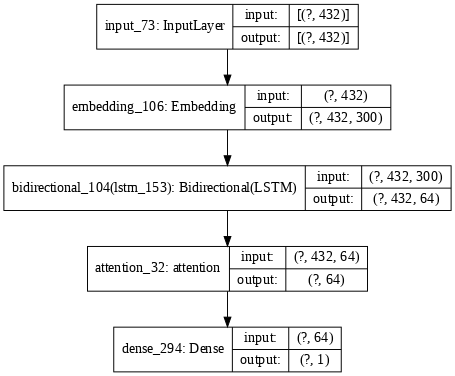

In [123]:
plot_model(model, to_file='model_plot_bilstm_att.png', show_shapes=True, show_layer_names=True, dpi = 70)